## **Plotting**

Here, we consider that all the networks of interest were already generated and saved. This way, we will augment the networks with extra information
and perform extra calculations to generate data ready for plotting.

Let us consider the two types of networks:<br>
1. **Cities flux networks**<br>
2. **Cities to Hospitals flux networks**<br>

## **-1. Lib**

In [1]:
# -- Bib
import os
import sys
sys.path.append("..")

import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import pickle
import glob
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon

import matplotlib
import matplotlib.pyplot as plt

In [2]:
idx = pd.IndexSlice


## **0. Load base data**

In [3]:
# -- base paths
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
#basepath = os.path.join(os.environ["HOME"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
geopath = os.path.join(basepath, "shapefilesceqgis")
gmlpath = os.path.join(basepath, "redes_aih")
figpath = os.path.join(basepath, "redes_aih", "macrofigs")

## **1. Maps of proposal**

In [7]:
# -- load geo
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))

In [8]:
border_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", "#ffb300": "#cc8f00", "#04ae81": "#037d5c"}

**Current Macro**

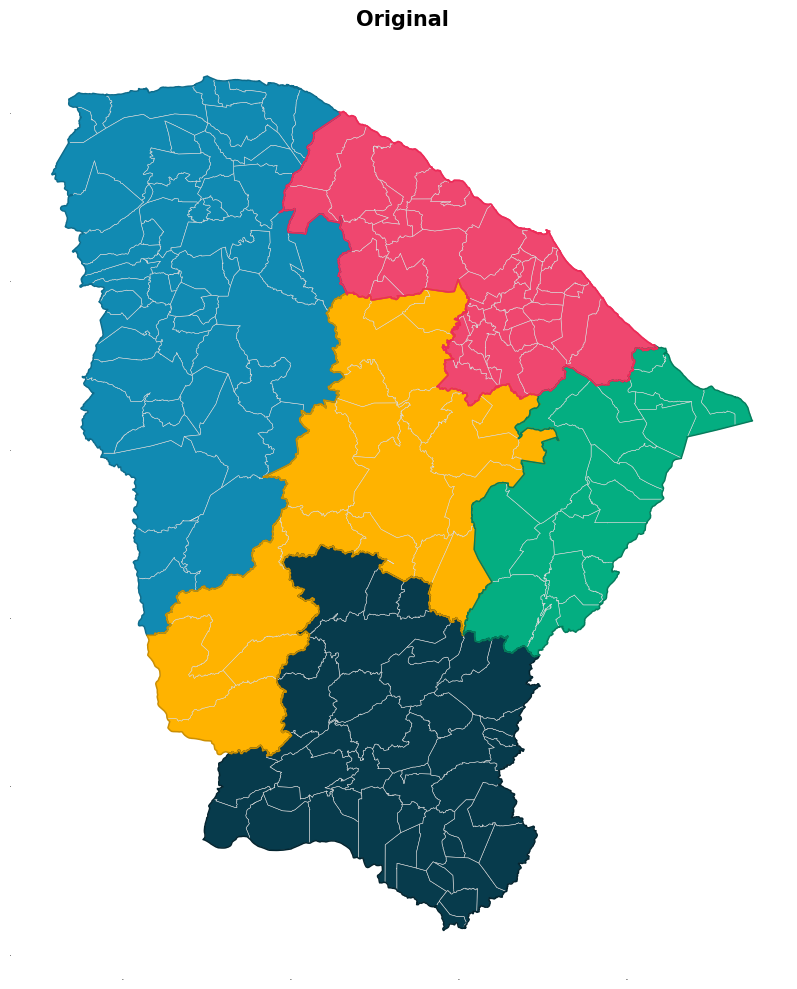

In [9]:
# -- new geometry ceará
fig_new, AX = plt.subplots(1, figsize=(12,10))

geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.4)
geodata_df.set_geometry('geometry_municip').plot(ax=AX, color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.4)

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=AX, color="none", edgecolor=macro_df["MACRO_COLOR"].map(border_macro), linewidth=1.1)
macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX, color="none", edgecolor="#ed2c59", linewidth=1.1)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [AX]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

AX.set_title("Original", fontsize=15, weight='bold')

fig_new.tight_layout()
fig_new.savefig(os.path.join(figpath, "original_macro.png"), dpi=250, bbox_inches='tight')

**Proposal**

In [10]:
proposal_color = {1: "#ef476f", 3: "#073b4c", 6:"#04ae81", 8:"#118ab2", 5: "#ffb300",
                  2: "#bb1190", 4: "#ef7347", 7:"#14b1eb"}

border_proposal_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", 
                         "#ffb300": "#cc8f00", "#04ae81": "#037d5c", "#14b1eb":"#108ebc",
                         "#bb1190": "#8c0d6c", "#ef7347": "#ed5f2c"}

In [11]:
new_macro_geometry = []
for index in range(1,9):
    new_macro_geometry.append( geodata_df[geodata_df["MACRO_ID_PROPOSAL"]==index]['geometry_municip'].unary_union )
    if index==1:
        new_macro_geometry[-1]  = gpd.GeoSeries([ Polygon(p.exterior) for p in list(new_macro_geometry[-1].geoms) ]).geometry.unary_union
    else:
        new_macro_geometry[-1] = Polygon(new_macro_geometry[-1].exterior)
new_macro_geometry = gpd.GeoDataFrame({'MACRO_ID_PROPOSAL': [ index for index in range(1,9)]}, geometry=new_macro_geometry)

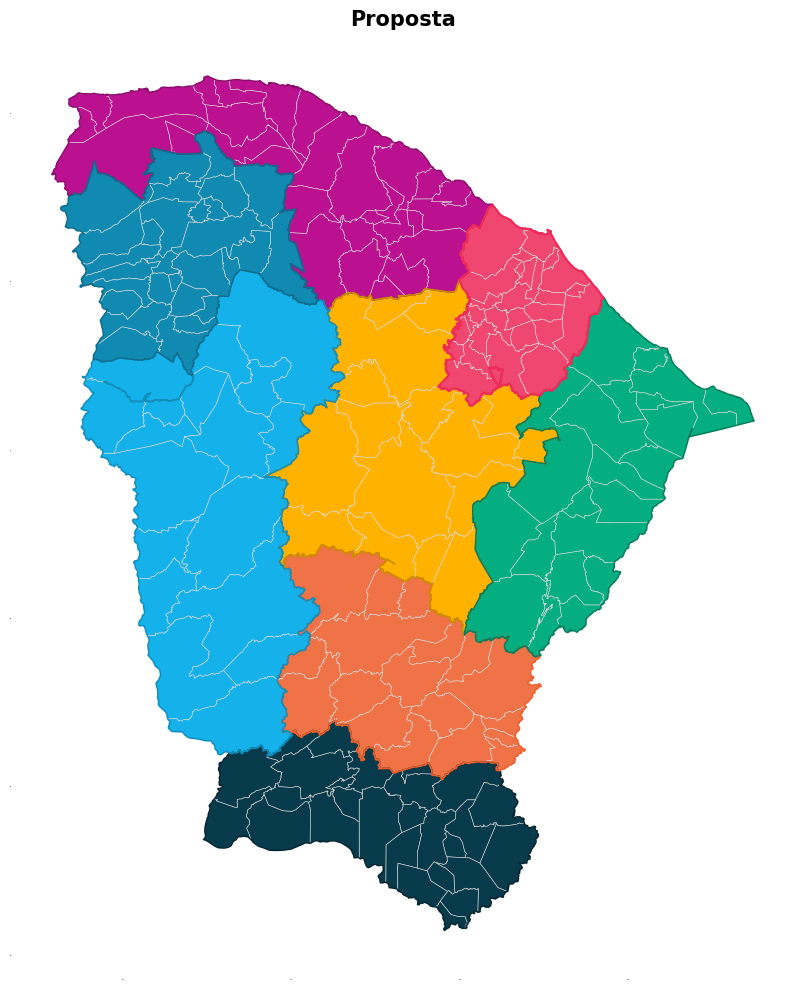

In [12]:
# -- new geometry ceará
fig_new, AX = plt.subplots(1, figsize=(12,10))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
geodata_df.set_geometry('geometry_municip').plot(ax=AX, color=geodata_df["MACRO_ID_PROPOSAL"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4)

new_macro_geometry.plot(ax=AX, color="none", edgecolor=new_macro_geometry["MACRO_ID_PROPOSAL"].map(proposal_color).map(border_proposal_macro), linewidth=1.1)
new_macro_geometry[new_macro_geometry["MACRO_ID_PROPOSAL"]==1].plot(ax=AX, color="none", edgecolor="#ed2c59", linewidth=1.5)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [AX]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

AX.set_title("Proposta", fontsize=15, weight='bold')

fig_new.tight_layout()
fig_new.savefig(os.path.join(figpath, "proposta_macro.png"), dpi=250, bbox_inches='tight')

**Separate macros**

In [13]:
cmap_macro_str = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}

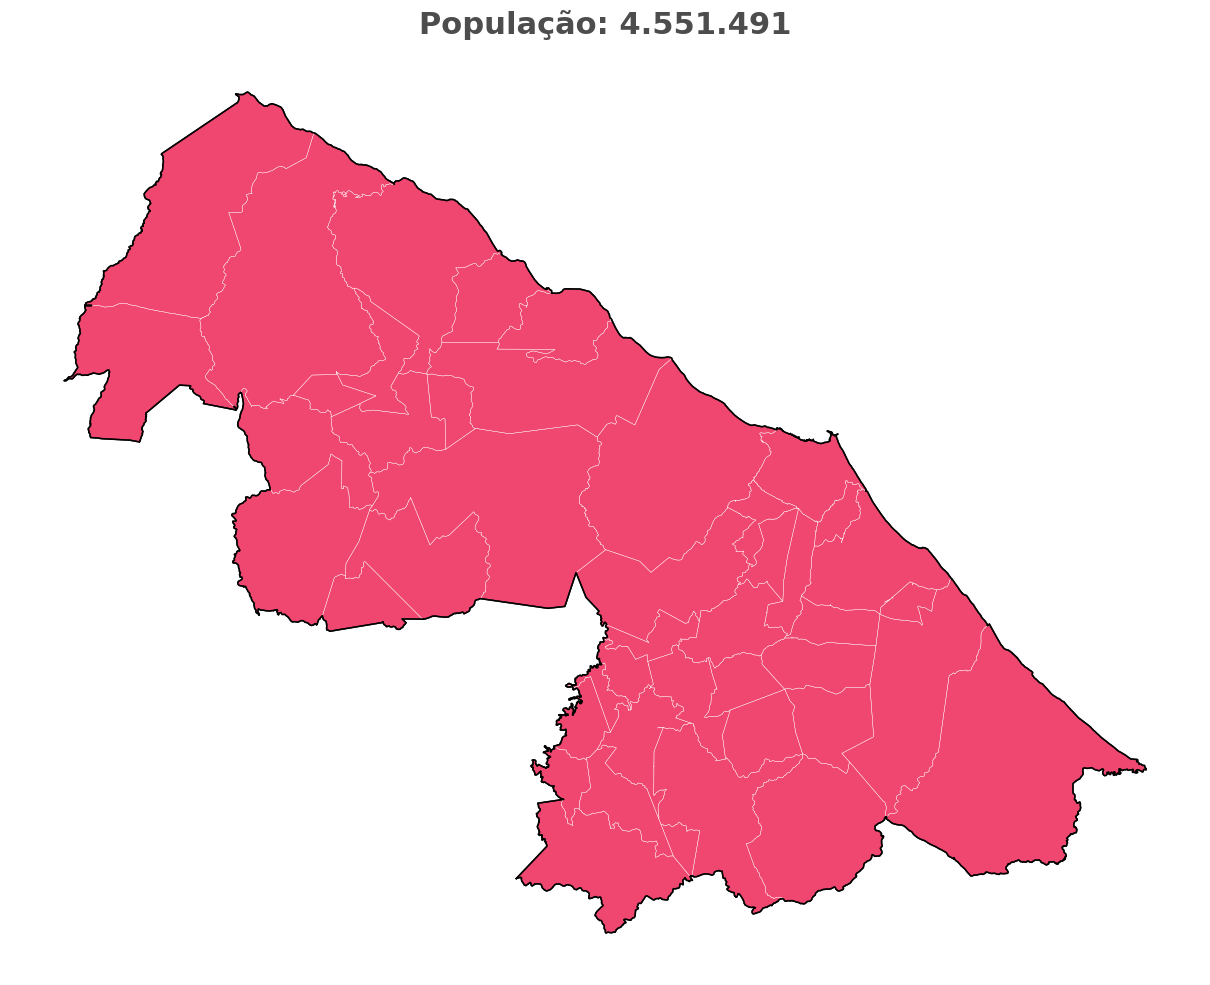

In [14]:
macro_id = 1

def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

def transf_label_macro(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[1]:,}'.replace(",",".")

popn_macro = geodata_df[geodata_df["MACRO_ID"]==macro_id]["2022"].sum()

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15,10))
geodata_df.set_geometry("geometry_municip")

macro_df = geodata_df[["MACRO_ID","2010", "2022"]].groupby("MACRO_ID").sum().reset_index().merge(geodata_df[["geometry_macro", "MACRO_ID"]].drop_duplicates("MACRO_ID"), on="MACRO_ID", how="left")
macro_df = gpd.GeoDataFrame(macro_df).set_geometry("geometry_macro")
macro_df = macro_df[macro_df["MACRO_ID"]==macro_id]
geodata_macro_df = geodata_df[geodata_df["MACRO_ID"]==macro_id]

macro_df.plot(ax=ax_mapa, color=cmap_macro_str[macro_id], edgecolor="#000000")

#macro_df.plot(ax=ax_mapa, column='2010', edgecolor="#000000", 
#             legend=True,
#             scheme="NaturalBreaks",
#             k=6,
#             cmap="PuBu",
#             linewidth=1.0,
#             legend_kwds={
#                 'loc': 4,
#                 'prop': {'size':19},
#                 'markerscale': 1.6,
#                 "fmt": "{:.0f}",
#                 "interval": True
#             },
#             missing_kwds={
#                 "color": "#ffffff",
#                 "edgecolor": "#999999",
#                 "hatch": "///",
#                 "label": '0',
#                 'alpha': 0.5
#             })

geodata_macro_df.plot(ax=ax_mapa, edgecolor="#ffffff", color='none', linewidth=0.25) 
macro_df.plot(ax=ax_mapa, color='none', edgecolor="#000000", linewidth=1.1) 


ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

# -- legend macro
#leg = ax_mapa.get_legend()
#lines = leg.get_lines()
#for line in lines:
#    cur_color = line.get_markerfacecolor() 
#    line.set_marker('s')
#    line.set_markersize(18)
#    #line.set_linestyle('-')
#    #line.set_linewidth(12)
#    #line.set_color(cur_color)
#current_labels = [t.get_text() for t in leg.get_texts()]
#new_labels =  [ transf_label_macro(index, label) for index, label in enumerate(current_labels) ]
#ax_mapa.legend(lines, new_labels, prop={'size': 17}, loc=4)

fig_mapa.suptitle(f"População: {popn_macro:,.0f}".replace(",","."), fontsize=22, color="#4d4d4d", weight='bold')
fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, f"macro_simples_id{macro_id}.png"), dpi=200, bbox_inches='tight')

## **2. Population, Hospitals**

In [15]:
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))

**2.1 City population 2010 and 2022**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


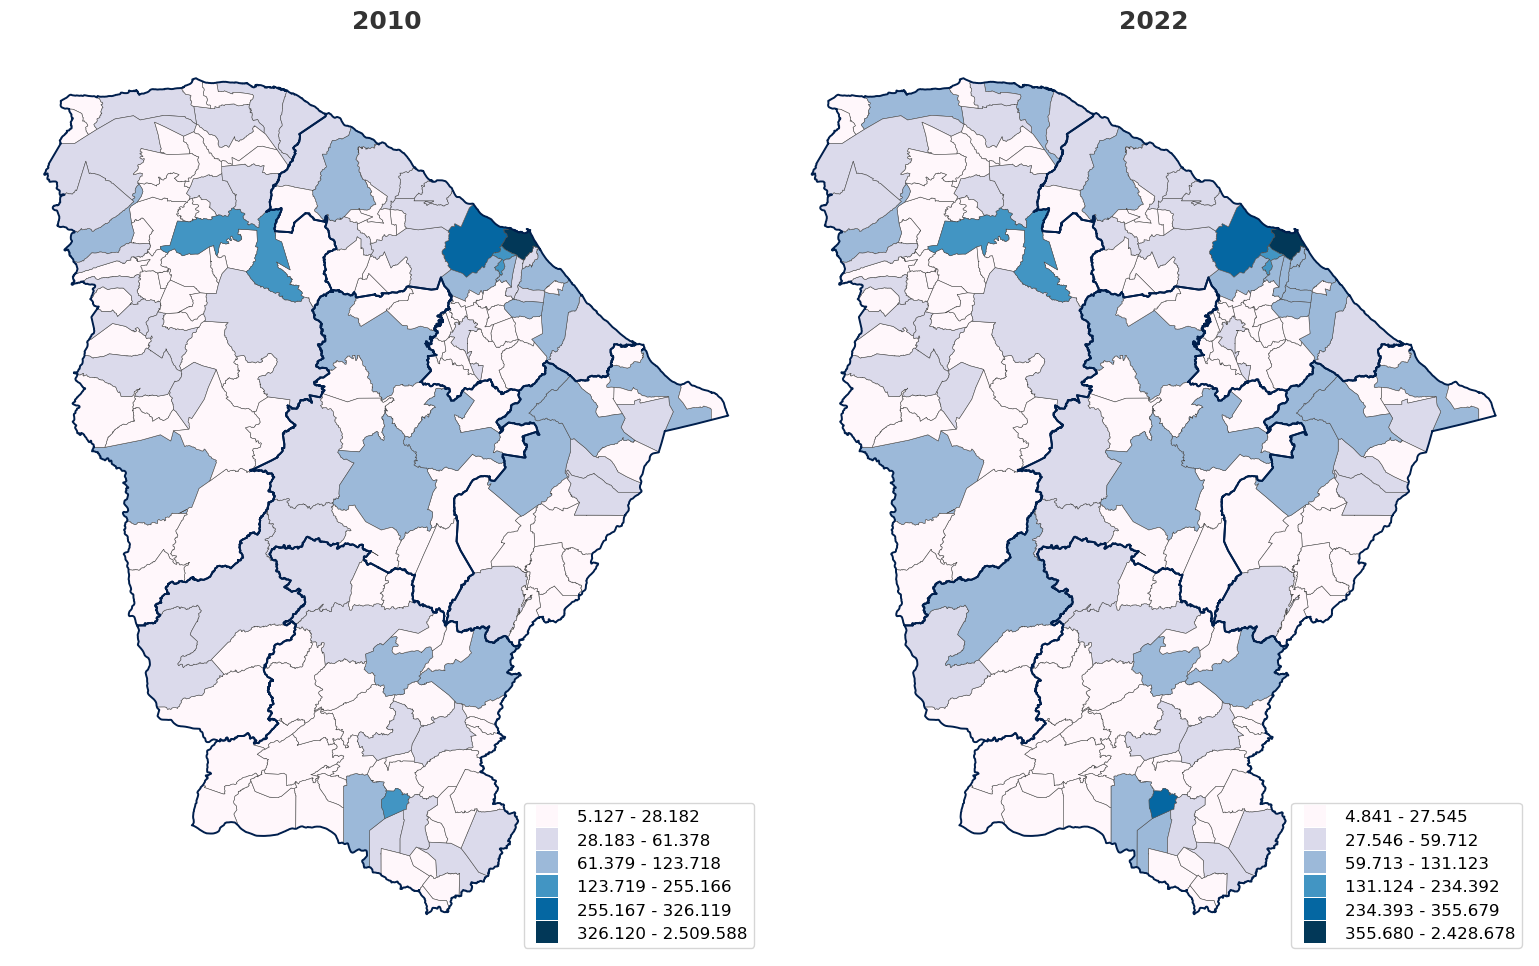

In [16]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, (ax_mapa, ax_mapa2) = plt.subplots(1,2, figsize=(15.5,10))
geodata_df.set_geometry("geometry_municip")

geodata_df.plot(ax=ax_mapa, column='2010', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="PuBu",
             linewidth=0.4,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

geodata_df.plot(ax=ax_mapa2, column='2022', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="PuBu",
             linewidth=0.4,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#001f4d", linewidth=1.4)
macro_df.plot(ax=ax_mapa2, color="none", edgecolor="#001f4d", linewidth=1.4)

ax_mapa.axis('off')
ax_mapa2.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)
ax_mapa2.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa, ax_mapa2]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(16)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 12}, loc=4)
    #axis.legend(lines, new_labels, prop={'size': 12}, loc=4, title='No. Habitantes', title_fontproperties={'weight': 'bold', 'size': 12})

ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
ax_mapa2.set_title("2022", weight='bold', fontsize=18, color="#333333")
fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, "pop_2010_2022.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_mapa_2013_vs_2022.pdf"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "tb", "figs", "mapa_casos_tbdr_municipio_2012_2023.png"), dpi=300, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "tb", "figs", "mapa_casos_tbdr_municipio_2012_2023.pdf"), dpi=200, bbox_inches='tight')

**2.2 Geolocation of health units**

In [17]:
valid_cnes_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry')

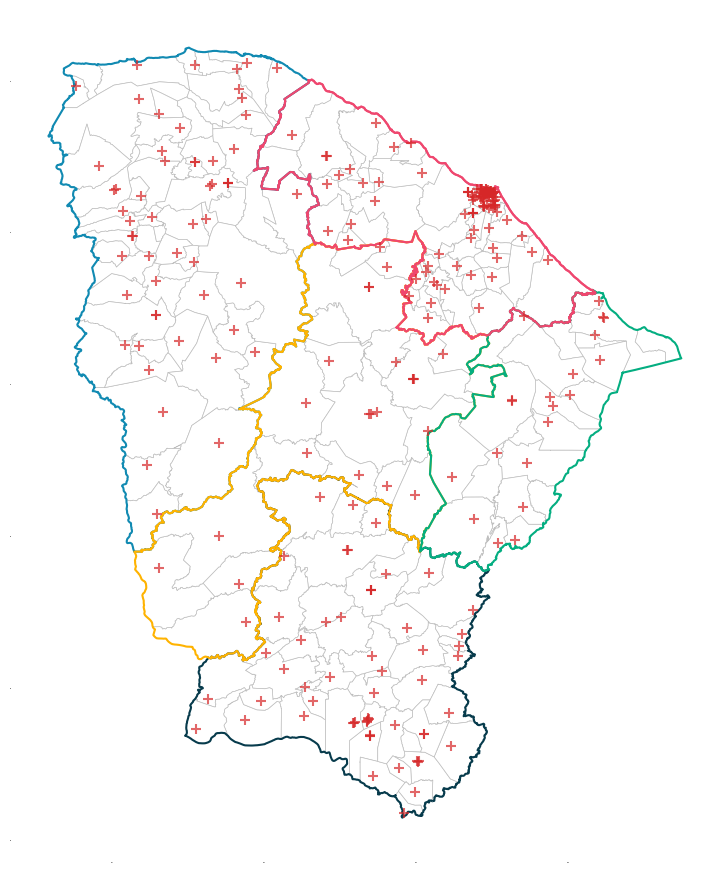

In [18]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(13,11))

geodata_df.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax1, color="none", edgecolor=macro_df["MACRO_COLOR"], linewidth=1.5)
macro_df[macro_df["MACRO_ID"]==1].plot(ax=ax1, color="none", edgecolor="#ef476f", linewidth=1.5)

valid_cnes_df.plot(ax=ax1, markersize=42, marker='+', alpha=0.7, color="tab:red")

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)


# -- node color
cmap_macro_str = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c"}
cmap_macro_str = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c"}

# -- edge color
cmap_edge_color = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c", "-1": "#9c9c9c"}
cmap_edge_color = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c", "-1": "#404040"}

fig1.savefig(os.path.join(figpath, "hospitals_2018_2306.png"), dpi=200, bbox_inches='tight')


**2.3 Hospitals and hospital beds**

In [23]:
leitos_muni_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_hospitais_por_municipio_1801_2306.parquet"))
geodata_df1 = geodata_df.merge(leitos_muni_df, on="GEOCOD6", how="left")

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


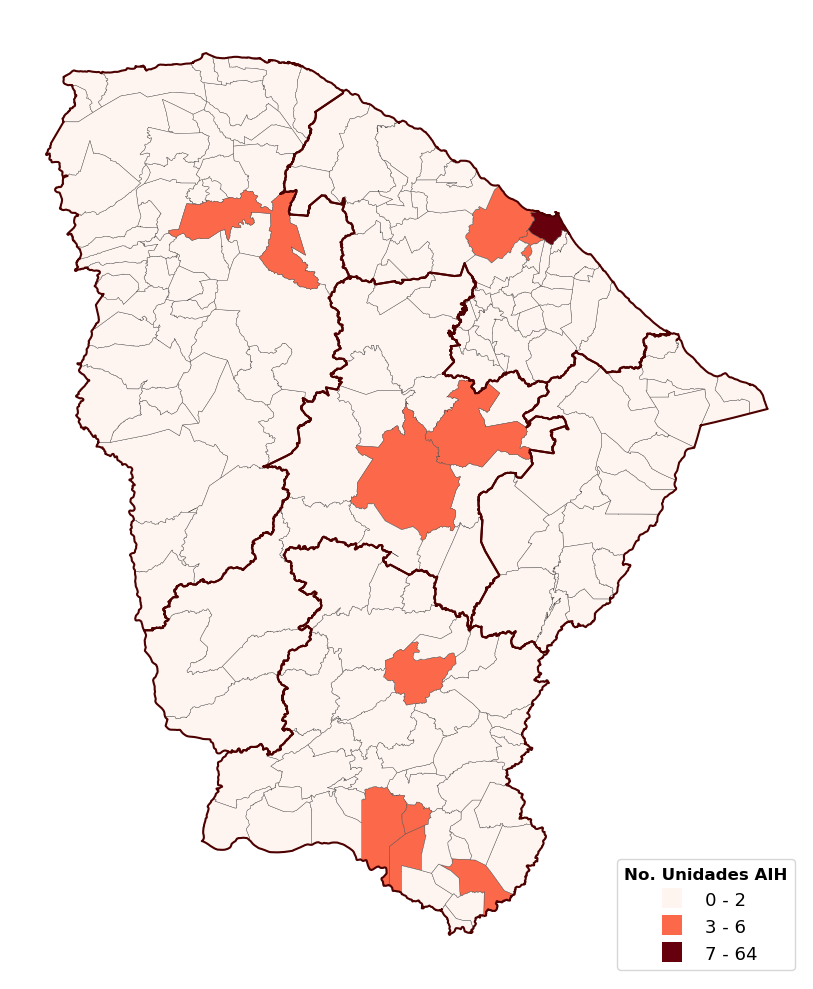

In [24]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df.set_geometry("geometry_municip")

geodata_df1.plot(ax=ax_mapa, column='NUMHOSPITAIS', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=3,
             cmap="Reds",
             linewidth=0.3,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)


ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title='No. Unidades AIH', title_fontproperties={'weight': 'bold', 'size': 12})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, "mapa_hospitais_2306.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_mapa_2013_vs_2022.pdf"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "tb", "figs", "mapa_casos_tbdr_municipio_2012_2023.png"), dpi=300, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


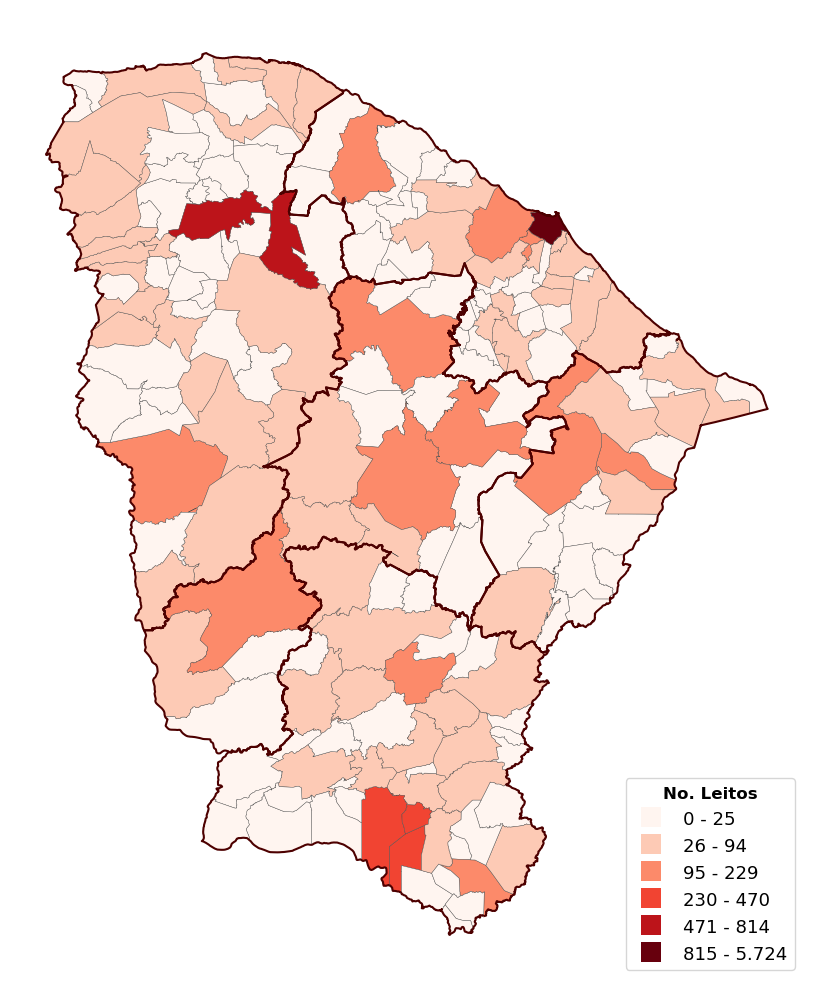

In [25]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df.set_geometry("geometry_municip")

geodata_df1.plot(ax=ax_mapa, column='NUMLEITOS', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="Reds",
             linewidth=0.3,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)


ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title='No. Leitos', title_fontproperties={'weight': 'bold', 'size': 12})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, "mapa_leitos_2306.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_mapa_2013_vs_2022.pdf"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "tb", "figs", "mapa_casos_tbdr_municipio_2012_2023.png"), dpi=300, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


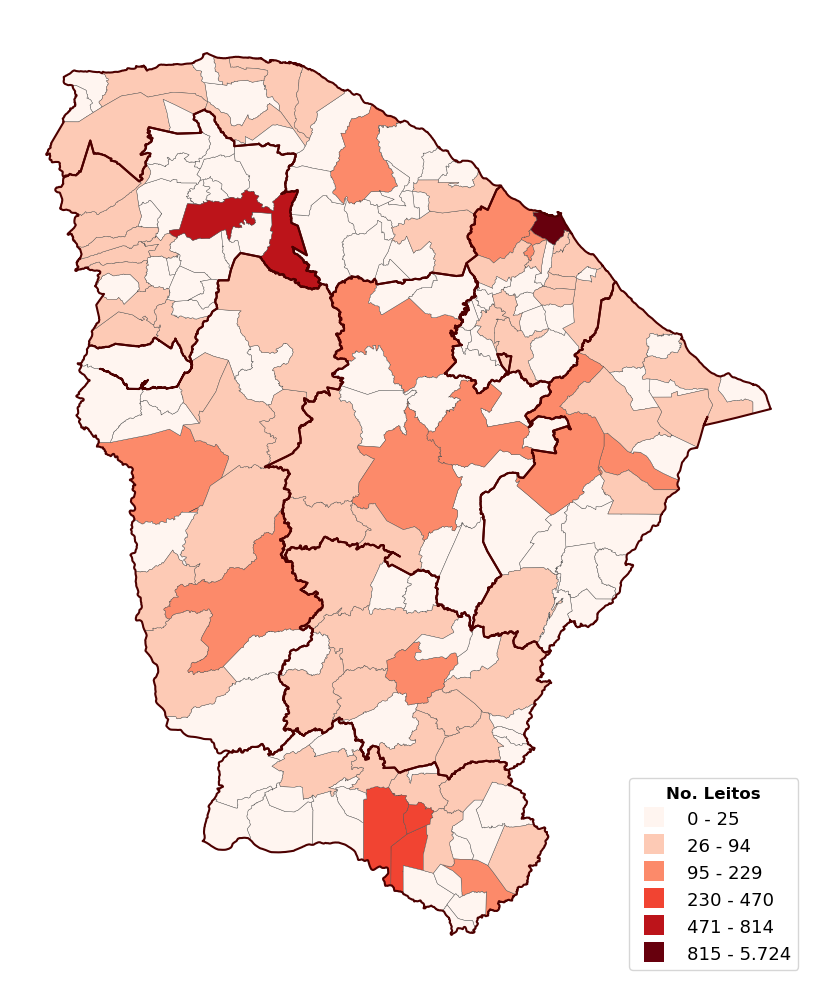

In [26]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df.set_geometry("geometry_municip")

geodata_df1.plot(ax=ax_mapa, column='NUMLEITOS', edgecolor="#4d4d4d", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="Reds",
             linewidth=0.3,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

#macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
#macro_df = macro_df.set_geometry("geometry_macro")
#macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)
new_macro_geometry.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)
#new_macro_geometry[new_macro_geometry["MACRO_ID_PROPOSAL"]==1].plot(ax=AX, color="none", edgecolor="#ed2c59", linewidth=1.5)


ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
        #line.set_linestyle('-')
        #line.set_linewidth(12)
        #line.set_color(cur_color)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title='No. Leitos', title_fontproperties={'weight': 'bold', 'size': 12})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.tight_layout()
fig_mapa.savefig(os.path.join(figpath, "mapa_leitos_macro_proposta_2306.png"), dpi=200, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_mapa_2013_vs_2022.pdf"), dpi=250, bbox_inches='tight')
#fig_mapa.savefig(os.path.join(basepath, "opas", "tb", "figs", "mapa_casos_tbdr_municipio_2012_2023.png"), dpi=300, bbox_inches='tight')

**Stats per macro (Original)**

In [27]:
leitos_muni_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_hospitais_por_municipio_1801_2306.parquet"))
geodata_df1 = geodata_df.merge(leitos_muni_df, on="GEOCOD6", how="left")

In [28]:
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_ID_PROPOSAL", "MACRO_NOME", "geometry_macro"]]
macro_df["MACRO_NOME"] = macro_df["MACRO_NOME"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
macro_id_to_nome = dict(zip(macro_df["MACRO_ID"], macro_df["MACRO_NOME"]))

health_units_per_macro = valid_cnes_df["MACRO_ID"].value_counts().reset_index().sort_values(by="MACRO_ID")
leitos_per_macro = geodata_df1.groupby("MACRO_ID")[["NUMLEITOS", "2022"]].sum().reset_index().sort_values(by="MACRO_ID")
leitos_per_macro["POPPLEITO"] = leitos_per_macro["2022"]/leitos_per_macro["NUMLEITOS"]
#pop_per_macro = geodata_df1.groupby("MACRO_ID")["NUMLEITOS"].sum().reset_index().sort_values(by="MACRO_ID")

health_units_per_macro["MACRO_ID"] = health_units_per_macro["MACRO_ID"].map(macro_id_to_nome)
leitos_per_macro["MACRO_ID"] = leitos_per_macro["MACRO_ID"].map(macro_id_to_nome)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\1632586048.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=15, weight='bold')


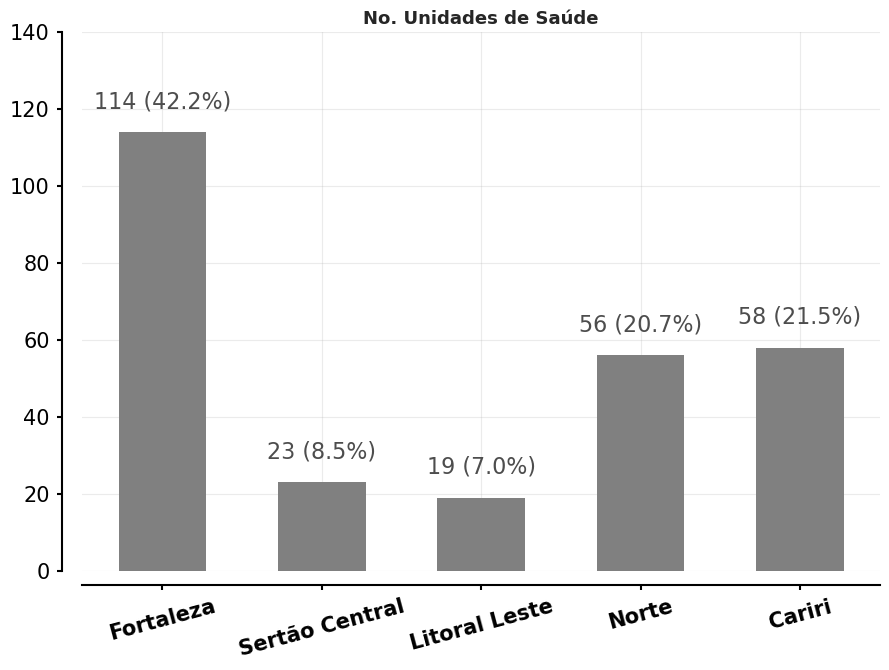

In [29]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(health_units_per_macro["MACRO_ID"], health_units_per_macro["count"], width=0.55, zorder=2, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)
#005c99"
ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 140])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = health_units_per_macro
serie_sum = serie_data['count'].sum()
for idx in range(len(serie_data['count'])):
    porc = (serie_data['count'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['count'].iloc[idx]+8, x=idx+0., s=f'{serie_data["count"].iloc[idx]:,} ({porc:.1f}%)', 
                ha='center', va='center', fontsize=16, color="#4d4d4d")
    
ax.set_title("No. Unidades de Saúde", fontsize=13, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=15, weight='bold')
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_original_unidades.png"), dpi=200, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.png"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.pdf"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.pdf"), dpi=200, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\875889125.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=10, weight='bold', color="#262626")


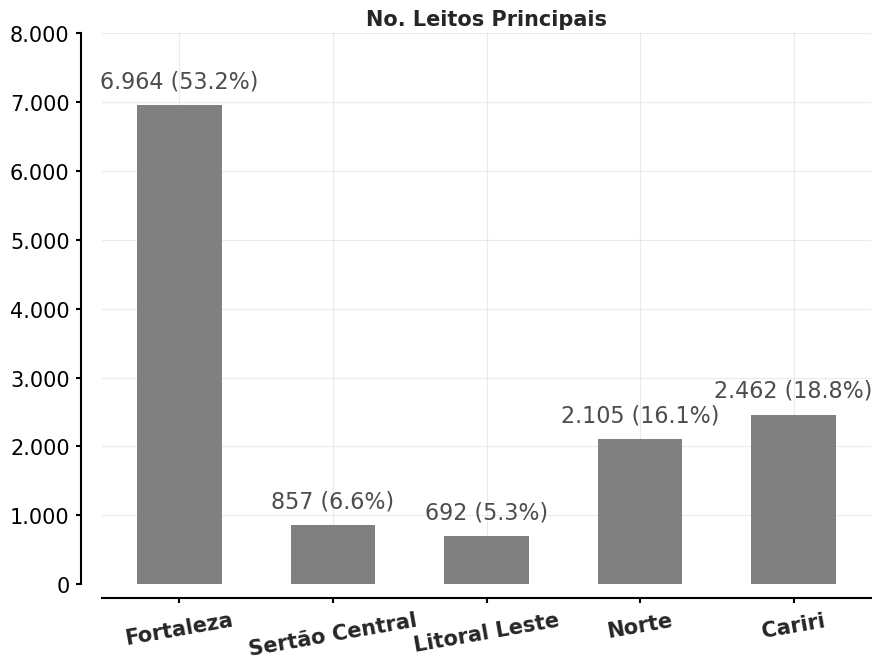

In [30]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(leitos_per_macro["MACRO_ID"], leitos_per_macro["NUMLEITOS"], width=0.55, zorder=2, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)

ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 8000])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = leitos_per_macro
serie_sum = serie_data['NUMLEITOS'].sum()
for idx in range(len(serie_data['NUMLEITOS'])):
    porc = (serie_data['NUMLEITOS'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['NUMLEITOS'].iloc[idx]+350, x=idx, s=f'{serie_data["NUMLEITOS"].iloc[idx]:,.0f} ({porc:.1f}%)'.replace(",","."), 
                ha='center', va='center', fontsize=16, color="#4d4d4d")
    
ax.set_title("No. Leitos Principais", fontsize=15, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=10, weight='bold', color="#262626")
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_original_leitos.png"), dpi=200, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.png"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.pdf"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.pdf"), dpi=200, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\3990895058.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=10, weight='bold', color="#262626")


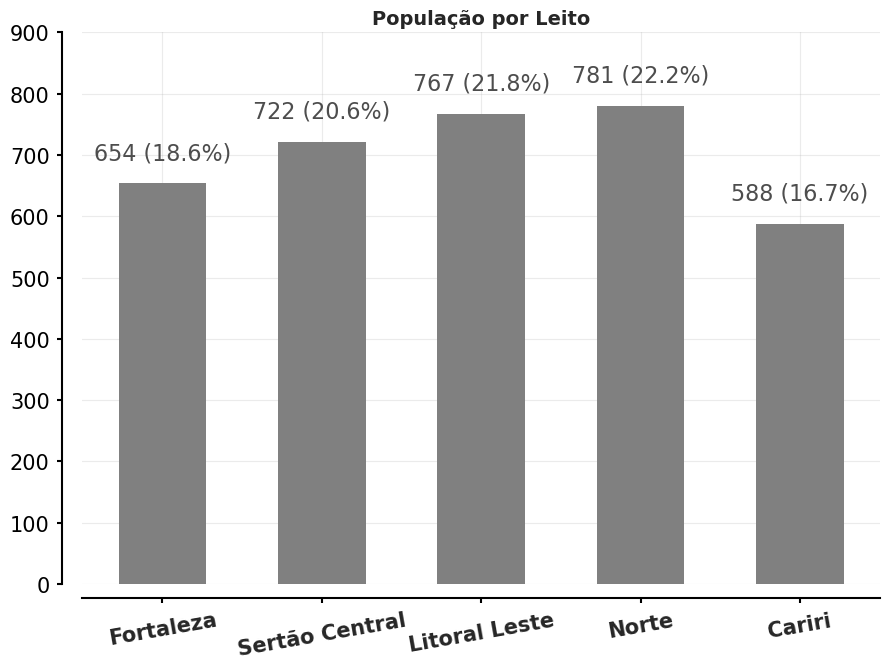

In [31]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(leitos_per_macro["MACRO_ID"], leitos_per_macro["POPPLEITO"], zorder=2, width=0.55, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)

ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 900])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = leitos_per_macro
serie_sum = serie_data['POPPLEITO'].sum()
for idx in range(len(serie_data['POPPLEITO'])):
    porc = (serie_data['POPPLEITO'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['POPPLEITO'].iloc[idx]+50, x=idx, s=f'{serie_data["POPPLEITO"].iloc[idx]:,.0f} ({porc:.1f}%)'.replace(",","."), 
                ha='center', va='center', fontsize=16, color="#4d4d4d")
    
ax.set_title("População por Leito", fontsize=14, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=10, weight='bold', color="#262626")
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_original_pop_por_leito.png"), dpi=200, bbox_inches='tight')

**Stats per macro (Proposta)**

In [32]:
leitos_muni_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_hospitais_por_municipio_1801_2306.parquet"))
geodata_df1 = geodata_df.merge(leitos_muni_df, on="GEOCOD6", how="left")

In [33]:
valid_cnes_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry')

In [34]:
valid_cnes_df.head()

CNES CODUFMUN  MACRO_ID  MACRO_ID_PROPOSAL  latitude  longitude  \
0    9999310   231130         2                  5 -4.970753 -39.014854   
611  9675787   230440         1                  1 -3.795548 -38.492201   
613  9672427   230760         3                  6 -5.089599 -38.121126   
635  9658815   230440         1                  1 -3.732426 -38.511244   
908  9526293   230440         1                  1 -3.771279 -38.474536   

    COMPETEN_MAX COMPETEN_MIN                    geometry  
0         202312       201912  POINT (-39.01485 -4.97075)  
611       202312       201812  POINT (-38.49220 -3.79555)  
613       202312       201811  POINT (-38.12113 -5.08960)  
635       202312       201811  POINT (-38.51124 -3.73243)  
908       202312       201806  POINT (-38.47454 -3.77128)

In [35]:
proposal_macro_nome = {
    1: "Fortaleza\nBaturité", 2: "Litoral Oeste", 3: "Cariri",
    4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Ibiapaba\nSertão de Sobral",
}

In [36]:
macro_df

MACRO_ID  MACRO_ID_PROPOSAL      MACRO_NOME  \
0         5                  3          Cariri   
1         1                  1       Fortaleza   
2         4                  2           Norte   
4         2                  7  Sertão Central   
7         3                  6   Litoral Leste   

                                      geometry_macro  
0  POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...  
1  MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...  
2  MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...  
4  POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...  
7  POLYGON ((-37.77077 -4.42713, -37.76948 -4.426...

In [37]:
macro_df = geodata_df.drop_duplicates("MACRO_ID_PROPOSAL", keep='first')[["MACRO_ID_PROPOSAL", "MACRO_NOME", "geometry_macro"]]
macro_df["MACRO_NOME"] = macro_df["MACRO_NOME"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
macro_df["MACRO_PROPOSAL_NOME"] = macro_df["MACRO_ID_PROPOSAL"].map(proposal_macro_nome)
macro_id_to_nome = dict(zip(macro_df["MACRO_ID_PROPOSAL"], macro_df["MACRO_PROPOSAL_NOME"]))

health_units_per_macro = valid_cnes_df["MACRO_ID_PROPOSAL"].value_counts().reset_index().sort_values(by="MACRO_ID_PROPOSAL")
leitos_per_macro = geodata_df1.groupby("MACRO_ID_PROPOSAL")[["NUMLEITOS", "2022"]].sum().reset_index().sort_values(by="MACRO_ID_PROPOSAL")
leitos_per_macro["POPPLEITO"] = leitos_per_macro["2022"]/leitos_per_macro["NUMLEITOS"]
#pop_per_macro = geodata_df1.groupby("MACRO_ID_PROPOSAL")["NUMLEITOS"].sum().reset_index().sort_values(by="MACRO_ID_PROPOSAL")

health_units_per_macro["MACRO_ID_PROPOSAL"] = health_units_per_macro["MACRO_ID_PROPOSAL"].map(macro_id_to_nome)
leitos_per_macro["MACRO_ID_PROPOSAL"] = leitos_per_macro["MACRO_ID_PROPOSAL"].map(macro_id_to_nome)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\596752376.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], fontsize=12, rotation=25, weight='bold')


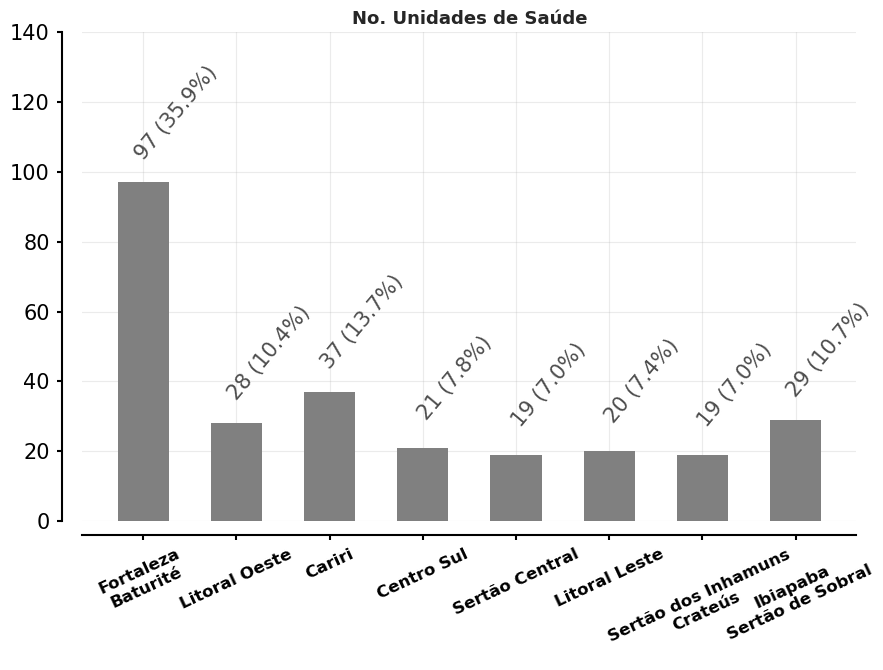

In [45]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(health_units_per_macro["MACRO_ID_PROPOSAL"], health_units_per_macro["count"], width=0.55, zorder=2, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)
#005c99"
ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 140])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = health_units_per_macro
serie_sum = serie_data['count'].sum()
for idx in range(len(serie_data['count'])):
    porc = (serie_data['count'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['count'].iloc[idx]+20, x=idx+0.35, s=f'{serie_data["count"].iloc[idx]:,} ({porc:.1f}%)', 
                ha='center', va='center', fontsize=15, color="#4d4d4d", rotation=50)
    
ax.set_title("No. Unidades de Saúde", fontsize=13, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], fontsize=12, rotation=25, weight='bold')
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_proposal_unidades.png"), dpi=200, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.png"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.pdf"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "tb", "figs", "raca_2012_2023.pdf"), dpi=200, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\2583808151.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=25, fontsize=10, weight='bold', color="#262626")


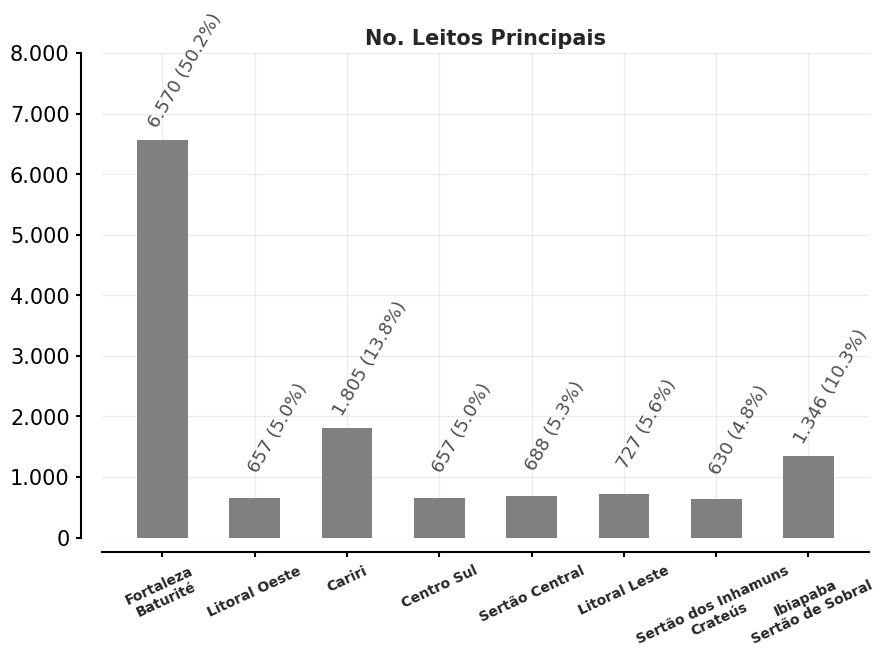

In [53]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(leitos_per_macro["MACRO_ID_PROPOSAL"], leitos_per_macro["NUMLEITOS"], width=0.55, zorder=2, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)

ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 8000])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = leitos_per_macro
serie_sum = serie_data['NUMLEITOS'].sum()
for idx in range(len(serie_data['NUMLEITOS'])):
    porc = (serie_data['NUMLEITOS'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['NUMLEITOS'].iloc[idx]+1150, x=idx+0.25, s=f'{serie_data["NUMLEITOS"].iloc[idx]:,.0f} ({porc:.1f}%)'.replace(",","."), 
                ha='center', va='center', fontsize=13, color="#4d4d4d", rotation=60)
    
ax.set_title("No. Leitos Principais", fontsize=15, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=25, fontsize=10, weight='bold', color="#262626")
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_proposal_leitos.png"), dpi=200, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.png"), dpi=250, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_both_lococor_2013_2023.pdf"), dpi=250, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\2833646915.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=25, weight='bold', fontsize=11, color="#262626")


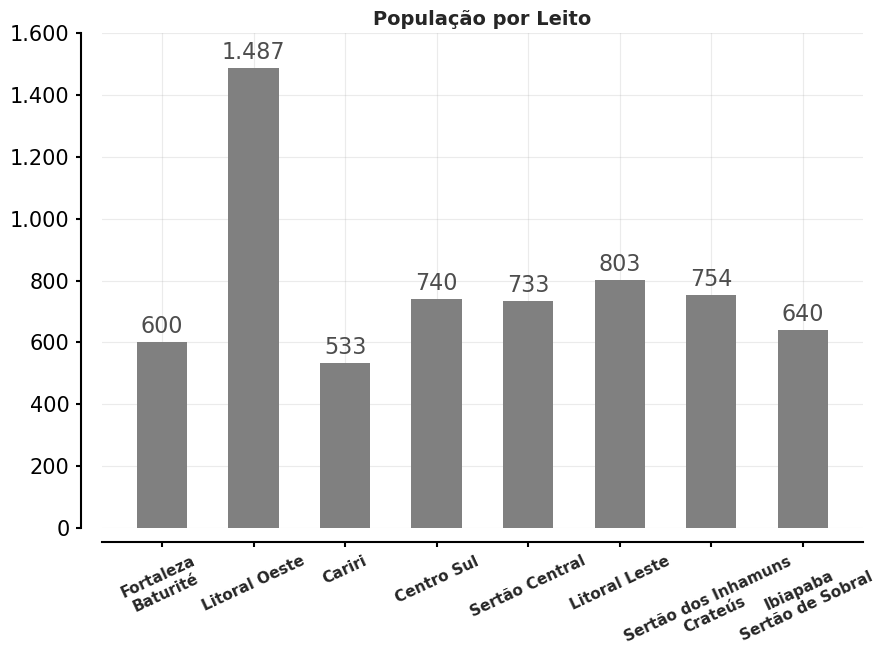

In [40]:
fig, ax = plt.subplots(1, figsize=(9,6.8))

for i in ['left', 'right', 'bottom', 'top']:
    ax.spines[i].set_linewidth(1.5)

for axis in [ax]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['left'].set_position(('outward', 15))
    axis.spines['bottom'].set_position(('outward', 10))
    axis.grid(alpha=0.25, zorder=0)

    axis.tick_params(direction='out', width=1.5, labelsize=15, pad=5)

ax.bar(leitos_per_macro["MACRO_ID_PROPOSAL"], leitos_per_macro["POPPLEITO"], zorder=2, width=0.55, color="#808080")
#ax_sel.bar(raca_count_sel[col_nm], raca_count_sel["count"], zorder=2, color="#005c99")
#ax.barh(idade_ms_fem.index, -1*idade_ms_fem, label="Feminino", zorder=2)

ax.tick_params(direction='out', width=1.5, labelsize=15, pad=5)
#ax.yaxis.set_tick_params(labelsize=15)
#ax.yaxis.set_tick_params(width=0)
ax.set_ylim([0, 1600])

ax.grid(alpha=0.25, zorder=0)
for axis in [ax]:
    axis.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(abs(x)), ',').replace(",", ".")))
#ax.legend(prop={'size':14}, loc=4)

serie_data = leitos_per_macro
serie_sum = serie_data['POPPLEITO'].sum()
for idx in range(len(serie_data['POPPLEITO'])):
    porc = (serie_data['POPPLEITO'].iloc[idx]/serie_sum)*100
    ax.text(y=serie_data['POPPLEITO'].iloc[idx]+50, x=idx, s=f'{serie_data["POPPLEITO"].iloc[idx]:,.0f}'.replace(",","."), 
                ha='center', va='center', fontsize=16, color="#4d4d4d")
    
ax.set_title("População por Leito", fontsize=14, weight='bold', color="#262626")
ax.set_xticklabels([ f for f in ax.get_xticklabels() ], rotation=25, weight='bold', fontsize=11, color="#262626")
fig.tight_layout()
#ax.set_title("Todos os óbitos", weight='bold', fontsize=15)
fig.savefig(os.path.join(figpath, "stats_macro_proposal_pop_por_leito.png"), dpi=200, bbox_inches='tight')

## **3. Geodesic distances to health services (Macros)** 

In [69]:
# -- load geo
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))

# -- create the two datasets
# -- one: geolocation of health units who genereated an AIH during 2018-2023 (this period can be flexible)
# -- two: geolocation of census units with the number of population contained in each unit
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df[["CNES", "CODUFMUN", "latitude", "longitude"]]
cnes_df = cnes_df.merge(geodata_df[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left").drop("GEOCOD6", axis=1)

pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "CD_GEOCODM", "geometry", "Pop_setor_censo2010"]].copy()
pop_census_df1["GEOCOD6"] = pop_census_df1["CD_GEOCODM"].apply(lambda x: x[:6])
pop_census_df1 = pop_census_df1.merge(geodata_df[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], on="GEOCOD6", how="left")
pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
pop_census_df1 = pop_census_df1.drop('geometry', axis=1).rename({'centroid': 'geometry'}, axis=1).set_geometry('geometry')
pop_census_df1 = pop_census_df1.to_crs(epsg=29194).copy()

# -- the city-hospital bipartite network can provide which health units are actually relevant for analysis (generated at least one AIH during the period chosen)
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

# -- filter only the relevant health units
valid_cnes = [ graph.nodes[v]['code'] for v in graph.nodes() if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0 ]
valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

# -- define the geometry of the health units
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry', crs="EPSG:4674")
# -- health units in projection for meters
valid_cnes_df1 = valid_cnes_df.to_crs(epsg=29194).copy()
#valid_cnes_df1 = valid_cnes_df.copy()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\3750053520.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_11020\3750053520.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)


**Macro distances (original)**

In [84]:
def get_distances_macro(macro_id, valid_cnes_df, pop_setor, macro_col="MACRO_ID"):
    '''
        does not consider the population of setor
    '''
    subset_cnes = valid_cnes_df1[valid_cnes_df[macro_col]==macro_id]
    subset_pop_setor = pop_setor[pop_setor[macro_col]==macro_id]
                                 
    #macro_distances = []
    #for index in range(subset_cnes.shape[0]):
    #    current_point_cnes = subset_cnes.geometry.iloc[index]
    #    lst_dist = (subset_pop_setor.distance(current_point_cnes)/1000)*subset_pop_setor["Pop_setor_censo2010"].apply(lambda x: np.ones(int(x)) if pd.notna(x) else np.array([]))
    #    macro_distances += lst_dist.apply(list).sum()

    macro_distances = subset_cnes.geometry.apply(lambda g: subset_pop_setor.distance(g)/1000).values.flatten() # km
    return macro_distances

def get_pop_weighted_distances_macro(macro_id, valid_cnes_df, pop_setor, macro_col="MACRO_ID"):
    '''

    '''
    subset_cnes = valid_cnes_df1[valid_cnes_df1[macro_col]==macro_id]
    subset_pop_setor = pop_census_df1[pop_census_df1[macro_col]==macro_id]

    weighted_distances = []
    for index in range(subset_cnes.shape[0]):
        current_point_cnes = subset_cnes.geometry.iloc[index]

        res = (subset_pop_setor.distance(current_point_cnes)/1000).apply(lambda x: [x] if pd.notna(x) else np.nan)*subset_pop_setor["Pop_setor_censo2010"].fillna(0).astype(int)
        weighted_distances.append(res)

    weighted_distances = pd.concat(weighted_distances)
    base_dist = []
    for lst in weighted_distances.values:
        base_dist += lst
    return base_dist


#macrodist1 = get_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1)
#macrodist2 = get_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1)
#macrodist3 = get_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1)
#macrodist4 = get_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1)
#macrodist5 = get_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1)

macrodist1 = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist2 = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist3 = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist4 = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist5 = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")


bins = np.arange(0,305,10)
va1, _ = np.histogram(macrodist1, bins)
va2, _ = np.histogram(macrodist2, bins)
va3, _ = np.histogram(macrodist3, bins)
va4, _ = np.histogram(macrodist4, bins)
va5, _ = np.histogram(macrodist5, bins)


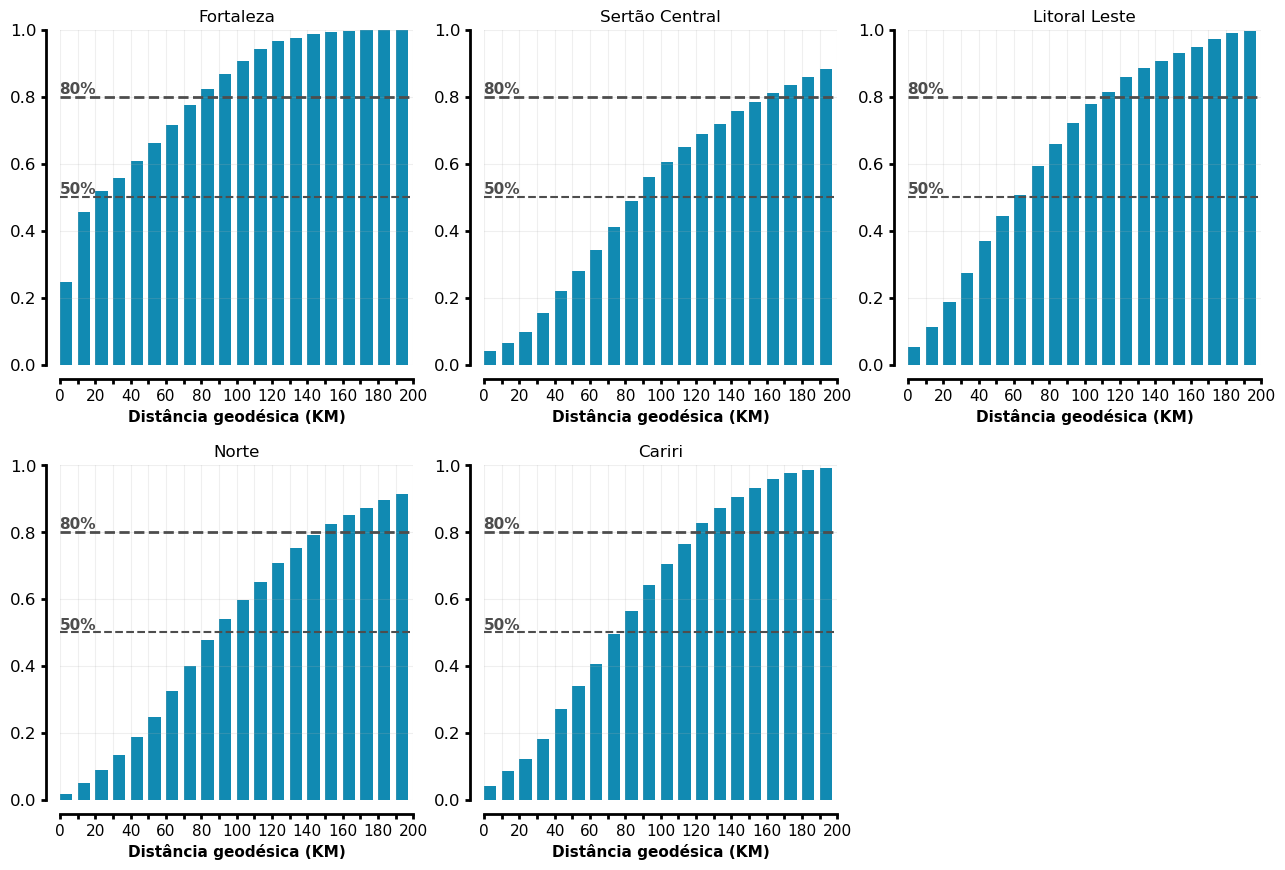

In [86]:
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_ID_PROPOSAL", "MACRO_NOME", "geometry_macro"]]
macro_df["MACRO_NOME"] = macro_df["MACRO_NOME"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
macro_id_to_nome = dict(zip(macro_df["MACRO_ID"], macro_df["MACRO_NOME"]))

fig, AX = plt.subplots(2, 3, figsize=(15.5,10))

bar_width = 7
AX[0,0].bar(height=va1.cumsum()/va1.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[0,1].bar(height=va2.cumsum()/va2.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[0,2].bar(height=va3.cumsum()/va3.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[1,0].bar(height=va4.cumsum()/va4.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[1,1].bar(height=va5.cumsum()/va5.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")

macro_cur_id = 0
for i in range(2):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        #AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        #AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)
        AX[i,j].set_xticks([n for n in bins[:-1]])
        AX[i,j].set_xticklabels([ f'{x:0.0f}' if x%20==0 else '' for x in bins[:-1] ])
        AX[i,j].set_xlim([0,200])
        AX[i,j].set_ylim([0,1])
        if i==1 and j==2:
            continue
        AX[i,j].axhline(y=0.8, ls="--", color="#4d4d4d", lw=2)
        AX[i,j].axhline(y=0.5, ls="--", color="#4d4d4d", lw=1.5)
        AX[i,j].text(x=10, y=0.81, s='80%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
        AX[i,j].text(x=10, y=0.51, s='50%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
        AX[i,j].set_xlabel("Distância geodésica (KM)", fontsize=11, weight='bold')
        AX[i,j].xaxis.set_tick_params(labelsize=11)
        AX[i,j].yaxis.set_tick_params(labelsize=12)

        if macro_cur_id<5:
            macro_nome = macro_id_to_nome[macro_cur_id+1]
            macro_cur_id+=1
            AX[i,j].set_title(macro_nome)

AX[1,2].axis('off')
#AX[0,0].set_ylabel("Fração de Setores Censitários", fontsize=11, weight='bold', labelpad=8)

fig.subplots_adjust(hspace=0.3)
fig.savefig(os.path.join(figpath, "stats_macro_original_distancias_unisaude_acum.png"), dpi=200, bbox_inches='tight')

**Macro distances (Proposta)**

In [71]:
macrodist1_prop = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist2_prop = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist3_prop = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist4_prop = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist5_prop = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist6_prop = get_pop_weighted_distances_macro(6, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist7_prop = get_pop_weighted_distances_macro(7, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")
macrodist8_prop = get_pop_weighted_distances_macro(8, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID_PROPOSAL")


bins = np.arange(0,305,10)
va1_prop, _ = np.histogram(macrodist1_prop, bins)
va2_prop, _ = np.histogram(macrodist2_prop, bins)
va3_prop, _ = np.histogram(macrodist3_prop, bins)
va4_prop, _ = np.histogram(macrodist4_prop, bins)
va5_prop, _ = np.histogram(macrodist5_prop, bins)
va6_prop, _ = np.histogram(macrodist6_prop, bins)
va7_prop, _ = np.histogram(macrodist7_prop, bins)
va8_prop, _ = np.histogram(macrodist8_prop, bins)


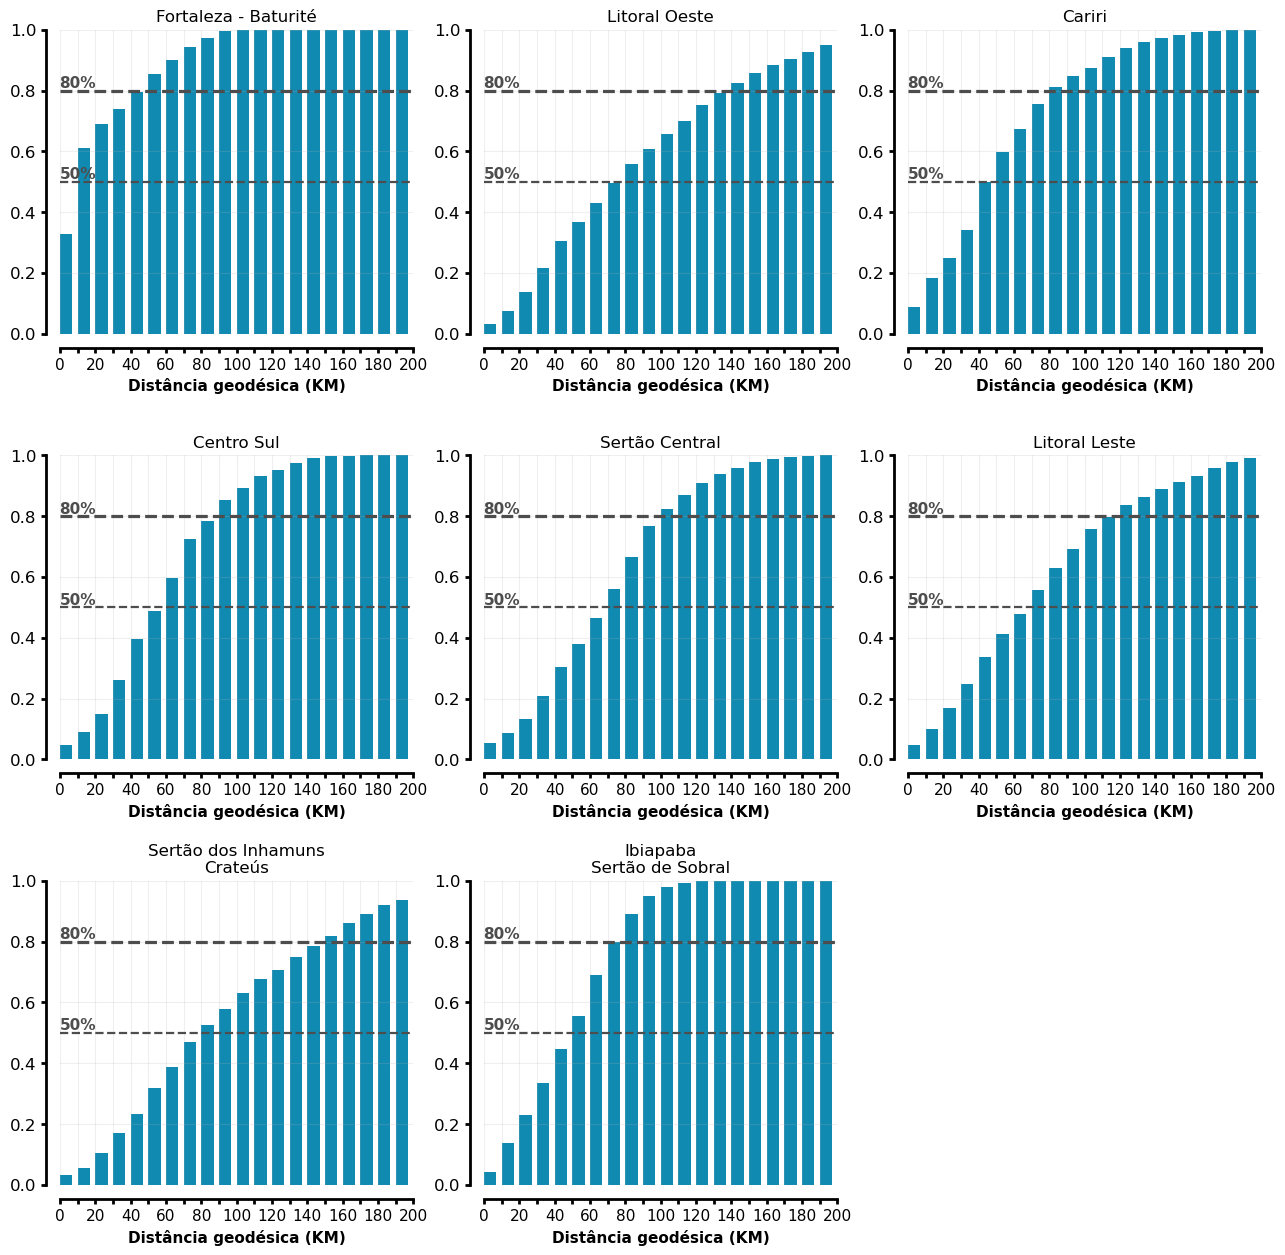

In [83]:
proposal_macro_nome = {
    1: "Fortaleza - Baturité", 2: "Litoral Oeste", 3: "Cariri",
    4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Ibiapaba\nSertão de Sobral",
}

fig, AX = plt.subplots(3, 3, figsize=(15.5,15))

bar_width = 7
AX[0,0].bar(height=va1_prop.cumsum()/va1_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[0,1].bar(height=va2_prop.cumsum()/va2_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[0,2].bar(height=va3_prop.cumsum()/va3_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[1,0].bar(height=va4_prop.cumsum()/va4_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[1,1].bar(height=va5_prop.cumsum()/va5_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[1,2].bar(height=va6_prop.cumsum()/va6_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[2,0].bar(height=va7_prop.cumsum()/va7_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")
AX[2,1].bar(height=va8_prop.cumsum()/va8_prop.sum(), x=bins[:-1], width=bar_width, align='edge', color="#118ab2")

macro_cur_id = 0
for i in range(3):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        #AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        #AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)
        AX[i,j].set_xticks([n for n in bins[:-1]])
        AX[i,j].set_xticklabels([ f'{x:0.0f}' if x%20==0 else '' for x in bins[:-1] ])
        AX[i,j].set_xlim([0,200])
        AX[i,j].set_ylim([0,1])
        if i==2 and j==2:
            continue
        AX[i,j].axhline(y=0.8, ls="--", color="#4d4d4d", lw=2.3)
        AX[i,j].axhline(y=0.5, ls="--", color="#4d4d4d", lw=1.6)
        AX[i,j].text(x=10, y=0.81, s='80%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
        AX[i,j].text(x=10, y=0.51, s='50%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
        AX[i,j].set_xlabel("Distância geodésica (KM)", fontsize=11, weight='bold')
        AX[i,j].xaxis.set_tick_params(labelsize=11)
        AX[i,j].yaxis.set_tick_params(labelsize=12)
        if macro_cur_id<8:
            macro_nome = proposal_macro_nome[macro_cur_id+1]
            macro_cur_id+=1
            AX[i,j].set_title(macro_nome)

AX[2,2].axis('off')
#AX[0,0].set_ylabel("Fração de Setores Censitários", fontsize=11, weight='bold', labelpad=8)

fig.subplots_adjust(hspace=0.4)
fig.savefig(os.path.join(figpath, "stats_macro_proposta_distancias_unisaude_acum.png"), dpi=200, bbox_inches='tight')

## **4. CCA for hospitals**

In [87]:
pop_censo_setores_df = gpd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cca_health_setores.parquet"))

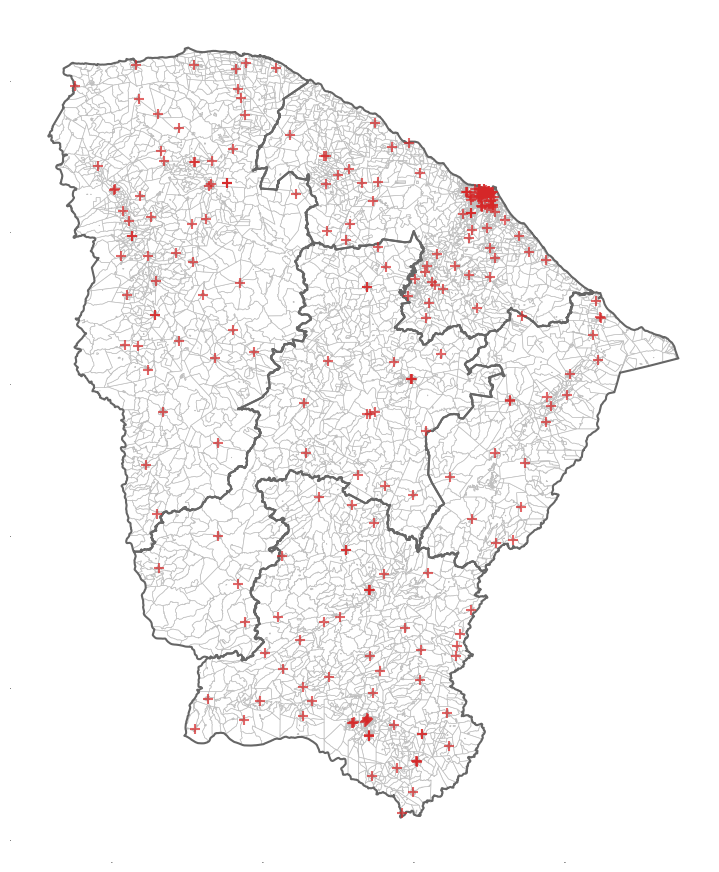

In [88]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(13,11))

pop_censo_setores_df.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax1, color="none", edgecolor="#666666", linewidth=1.5)
#macro_df[macro_df["MACRO_ID"]==1].plot(ax=ax1, color="none", edgecolor="#ef476f", linewidth=1.5)

valid_cnes_df.plot(ax=ax1, markersize=42, marker='+', alpha=0.7, color="tab:red")

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)


# -- node color
cmap_macro_str = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c"}
cmap_macro_str = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c"}

# -- edge color
cmap_edge_color = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c", "-1": "#9c9c9c"}
cmap_edge_color = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c", "-1": "#404040"}

fig1.savefig(os.path.join(figpath, "hospitals_2018_2306_cca_base.png"), dpi=200, bbox_inches='tight')

**Plotting for CCA diagram**

In [93]:
pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "CD_GEOCODM", "geometry", "Pop_setor_censo2010"]].copy()
pop_census_df1["GEOCOD6"] = pop_census_df1["CD_GEOCODM"].apply(lambda x: x[:6])
pop_census_df1 = pop_census_df1.merge(geodata_df[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], on="GEOCOD6", how="left")
#pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid

In [96]:
valid_cnes_df

CNES CODUFMUN  latitude  longitude  MACRO_ID  MACRO_ID_PROPOSAL  \
0      9999310   231130 -4.970753 -39.014854         2                  5   
611    9675787   230440 -3.795548 -38.492201         1                  1   
613    9672427   230760 -5.089599 -38.121126         3                  6   
635    9658815   230440 -3.732426 -38.511244         1                  1   
908    9526293   230440 -3.771279 -38.474536         1                  1   
...        ...      ...       ...        ...       ...                ...   
16457  0156647   230280 -4.361886 -39.313771         2                  5   
16458  0153087   230640 -3.496534 -39.597289         1                  2   
16524  0104477   230440 -3.742621 -38.536761         1                  1   
16525  0100358   231290 -3.685556 -40.345703         4                  8   
16527  0086673   230440 -3.739946 -38.510401         1                  1   

                         geometry  
0      POINT (-39.01485 -4.97075)  
611    POINT (-38.49220 -3.79555)  
613    POINT (-38.12113 -5.08960)  
635    POINT (-38.51124 -3.73243)  
908    POINT (-38.47454 -3.77128)  
...                           ...  
16457  POINT (-39.31377 -4.36189)  
16458  POINT (-39.59729 -3.49653)  
16524  POINT (-38.53676 -3.74262)  
16525  POINT (-40.34570 -3.68556)  
16527  POINT (-38.51040 -3.73995)  

[270 rows x 7 columns]

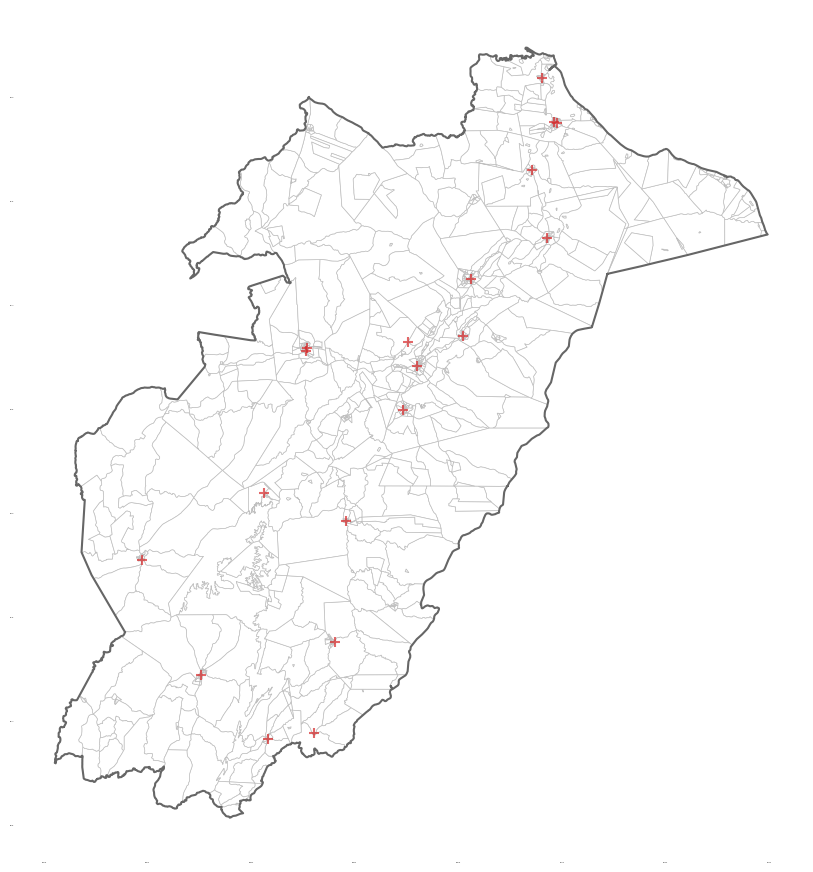

In [99]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(13,11))

macro_id = 3
pop_setores_sub = pop_census_df1[pop_census_df1["MACRO_ID"]==macro_id]
pop_setores_sub.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df[macro_df["MACRO_ID"]==macro_id]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax1, color="none", edgecolor="#666666", linewidth=1.5)
#macro_df[macro_df["MACRO_ID"]==1].plot(ax=ax1, color="none", edgecolor="#ef476f", linewidth=1.5)

valid_cnes_df[valid_cnes_df["MACRO_ID"]==macro_id].plot(ax=ax1, markersize=42, marker='+', alpha=0.7, color="tab:red")

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)


# -- node color
cmap_macro_str = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c"}
cmap_macro_str = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c"}

# -- edge color
cmap_edge_color = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c", "-1": "#9c9c9c"}
cmap_edge_color = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c", "-1": "#404040"}

fig1.savefig(os.path.join(figpath, f"cca_drawing_macro_{macro_id}.svg"), dpi=300, bbox_inches='tight')

**Algorithm**

In [118]:
pop_censo_setores_df = gpd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cca_health_setores.parquet"))
leitos_cca_hospitais_df = gpd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cca_health_hospitais.parquet"))

In [119]:
l = 5
quant_leitos_cca = leitos_cca_hospitais_df.groupby(f"cca_health_module_l{l}")["NUMLEITOS_TOTAL"].sum().reset_index()
map_leitos_cca = dict(zip(quant_leitos_cca[f"cca_health_module_l{l}"], quant_leitos_cca["NUMLEITOS_TOTAL"]))
leitos_cca_hospitais_df[f"NUMLEITOS_TOTAL_CCA_L{l}"] = leitos_cca_hospitais_df[f"cca_health_module_l{l}"].map(map_leitos_cca)

In [120]:
leitos_cca_hospitais_df.head()

CNES  latitude  longitude                    geometry  \
0    9999310 -4.970753 -39.014854  POINT (-39.01485 -4.97075)   
611  9675787 -3.795548 -38.492201  POINT (-38.49220 -3.79555)   
613  9672427 -5.089599 -38.121126  POINT (-38.12113 -5.08960)   
635  9658815 -3.732426 -38.511244  POINT (-38.51124 -3.73243)   
908  9526293 -3.771279 -38.474536  POINT (-38.47454 -3.77128)   

     cca_health_module_l5  cca_health_module_l10  cca_health_module_l15  \
0                      22                     22                     22   
611                     0                      0                      0   
613                   267                    123                    122   
635                     0                      0                      0   
908                     0                      0                      0   

     cca_health_module_l20  cca_health_module_l25  NUMLEITOS_TOTAL  \
0                       17                     17              0.0   
611                      0                      0              2.0   
613                     14                     44            142.0   
635                      0                      0              4.0   
908                      0                      0             25.0   

     NUMLEITOS_TOTAL_CCA_L5  
0                     206.0  
611                  6569.0  
613                   142.0  
635                  6569.0  
908                  6569.0

In [121]:
pop_cca_valid = pop_censo_setores_df[pop_censo_setores_df[f"cca_health_module_l{l}"]!=-1]
quant_pop_cca = pop_cca_valid.groupby(f"cca_health_module_l{l}")["Pop_setor_censo2010"].sum().reset_index()
map_pop_cca = dict(zip(quant_pop_cca[f"cca_health_module_l{l}"], quant_pop_cca["Pop_setor_censo2010"]))
pop_censo_setores_df[f"POP_TOTAL_CCA_L{l}"] = pop_censo_setores_df[f"cca_health_module_l{l}"].map(map_pop_cca)

In [122]:
pop_censo_setores_df = pop_censo_setores_df.merge(leitos_cca_hospitais_df[[f"cca_health_module_l{l}", f"NUMLEITOS_TOTAL_CCA_L{l}"]], on=f"cca_health_module_l{l}", how="left")
pop_censo_setores_df["População por leitos"] = (pop_censo_setores_df[f"POP_TOTAL_CCA_L{l}"]/pop_censo_setores_df[f"NUMLEITOS_TOTAL_CCA_L{l}"])#.fillna(0)

In [123]:
pop_censo_setores_df.head()

ID       CD_GEOCODI    TIPO CD_GEOCODB NM_BAIRRO   CD_GEOCODS NM_SUBDIST  \
0  9098  230030925000003   RURAL       None      None  23003092500       None   
1  9099  230030925000004   RURAL       None      None  23003092500       None   
2  9100  230030925000005   RURAL       None      None  23003092500       None   
3  9101  230030925000006   RURAL       None      None  23003092500       None   
4  9102  230030925000007  URBANO       None      None  23003092500       None   

  CD_GEOCODD     NM_DISTRIT CD_GEOCODM  ...        Cod_setor  \
0  230030925  SANTA FELÍCIA    2300309  ...  230030925000003   
1  230030925  SANTA FELÍCIA    2300309  ...  230030925000004   
2  230030925  SANTA FELÍCIA    2300309  ...  230030925000005   
3  230030925  SANTA FELÍCIA    2300309  ...  230030925000006   
4  230030925  SANTA FELÍCIA    2300309  ...  230030925000007   

  Pop_setor_censo2010 cca_health_module_l5 cca_health_module_l10  \
0               377.0                   -1                    -1   
1               199.0                   -1                    -1   
2               636.0                   -1                    -1   
3               437.0                   -1                    -1   
4               409.0                   -1                    -1   

  cca_health_module_l15  cca_health_module_l20  cca_health_module_l25  \
0                    -1                     25                     24   
1                    25                     25                     25   
2                    -1                     -1                     24   
3                    -1                     -1                     25   
4                    -1                     24                     24   

   POP_TOTAL_CCA_L5  NUMLEITOS_TOTAL_CCA_L5  População por leitos  
0               NaN                     NaN                   NaN  
1               NaN                     NaN                   NaN  
2               NaN                     NaN                   NaN  
3               NaN                     NaN                   NaN  
4               NaN                     NaN                   NaN  

[5 rows x 24 columns]

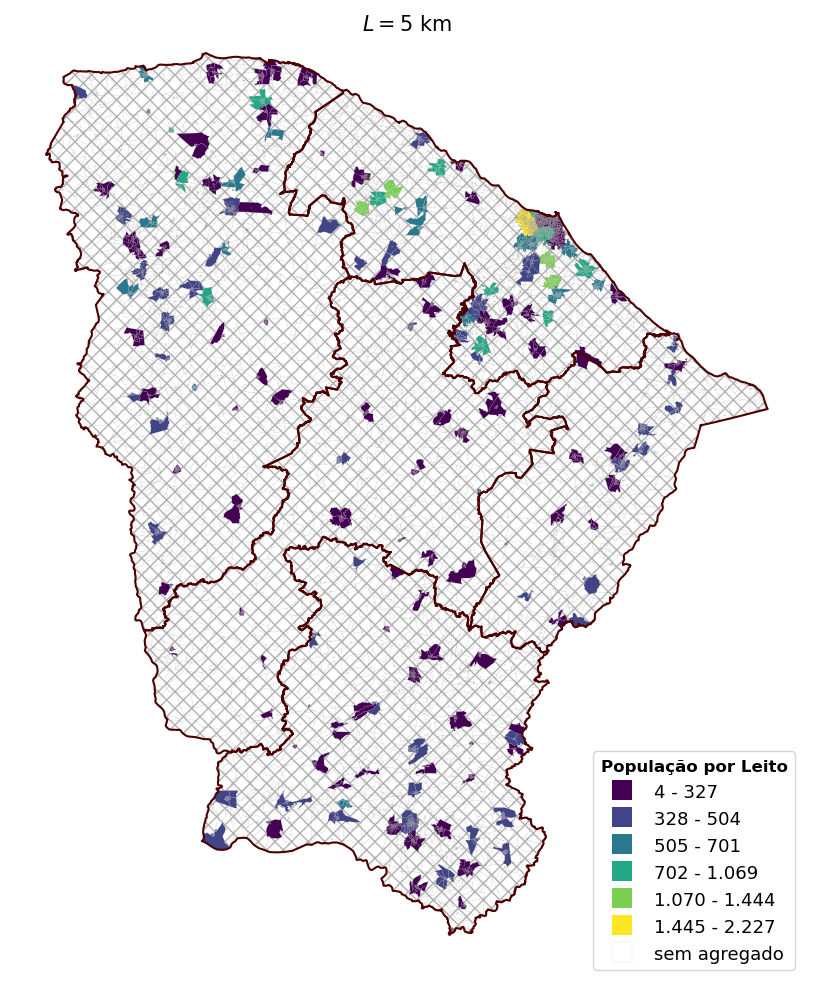

In [124]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

#cmap_range = colors = plt.cm.reds(np.linspace(0,1,18)) # -- colormap for the ranking

pop_censo_setores_df.plot(ax=ax_mapa, column='População por leitos', edgecolor="#b3b2b2", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="viridis",
             linewidth=0.1,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "xx",
                 "label": 'sem agregado',
                 'alpha': 0.4
             })

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title='População por Leito', title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
fig_mapa.suptitle(rf"$L = {l}$ km", fontsize=15)
fig_mapa.savefig(os.path.join(figpath, f"pop_por_leitos_cca_cluster_l{l}km.png"), dpi=250, bbox_inches='tight')

**Algorithm (v2)**

In [28]:
cca_results = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "sector_modules_cca_lhosp8.parquet")).reset_index()
pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
geodata_df1 = geodata_df.copy()

cca_results["GEOCOD6"] = cca_results["CD_GEOCODI"].apply(lambda x: x[:6])
cca_results = cca_results.merge(geodata_df1[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], on="GEOCOD6", how="left")
cca_results = cca_results.merge(pop_census_df[["CD_GEOCODI", "Pop_setor_censo2010"]], on="CD_GEOCODI", how="left")

In [63]:
pairs = []
for lhos in [8,10,12,14,16,18,20,22]:
    for lsector in np.arange(lhos, 38, 2):
        pairs.append((lsector, lhos))

#pairs_emptyness = []
xaxis = np.arange(8, 24, 2)
yaxis = np.arange(8, 38, 2)
im = np.zeros((yaxis.shape[0], xaxis.shape[0]))

for xindex, lhos in enumerate(xaxis):
    for yindex, lsec in enumerate(yaxis):
        if lsec<lhos:
            continue

        # -- process
        cca_results = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"sector_modules_cca_lhosp{lhos}.parquet")).reset_index()
        cca_results["GEOCOD6"] = cca_results["CD_GEOCODI"].apply(lambda x: x[:6])
        cca_results = cca_results.merge(geodata_df1[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], on="GEOCOD6", how="left")
        cca_results = cca_results.merge(pop_census_df[["CD_GEOCODI", "Pop_setor_censo2010"]], on="CD_GEOCODI", how="left")

        emptiness = cca_results[cca_results[f'module_lsec{lsec}_lhos{lhos}']==-1]['Pop_setor_censo2010'].sum()
        im[yindex, xindex] = (emptiness/8738000)*100

In [64]:
im.shape

(15, 8)

[Text(0, 0, '8'),
 Text(0, 1, '10'),
 Text(0, 2, '12'),
 Text(0, 3, '14'),
 Text(0, 4, '16'),
 Text(0, 5, '18'),
 Text(0, 6, '20'),
 Text(0, 7, '22'),
 Text(0, 8, '24'),
 Text(0, 9, '26'),
 Text(0, 10, '28'),
 Text(0, 11, '30'),
 Text(0, 12, '32'),
 Text(0, 13, '34'),
 Text(0, 14, '36')]

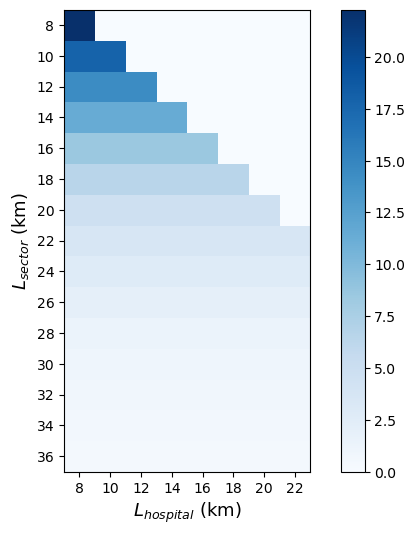

In [65]:
fig, ax = plt.subplots(1, figsize=(8,6))

c = ax.imshow(im, cmap="Blues")
plt.colorbar(c)

ax.set_ylabel(r"$L_{sector}$ (km)", fontsize=13)
ax.set_xlabel(r"$L_{hospital}$ (km)", fontsize=13)
ax.set_xticks([n for n in range(xaxis.shape[0])])
ax.set_yticks([n for n in range(yaxis.shape[0])])
ax.set_xticklabels(xaxis)
ax.set_yticklabels(yaxis)

In [25]:
pop_census_df

ID       CD_GEOCODI    TIPO CD_GEOCODB NM_BAIRRO   CD_GEOCODS  \
0       9098  230030925000003   RURAL       None      None  23003092500   
1       9099  230030925000004   RURAL       None      None  23003092500   
2       9100  230030925000005   RURAL       None      None  23003092500   
3       9101  230030925000006   RURAL       None      None  23003092500   
4       9102  230030925000007  URBANO       None      None  23003092500   
...      ...              ...     ...        ...       ...          ...   
13610  22486  231410225000006   RURAL       None      None  23141022500   
13611  22487  231410225000007  URBANO       None      None  23141022500   
13612  22488  231410225000008   RURAL       None      None  23141022500   
13613  22489  231410225000009   RURAL       None      None  23141022500   
13614  22490  231410225000010   RURAL       None      None  23141022500   

      NM_SUBDIST CD_GEOCODD     NM_DISTRIT CD_GEOCODM       NM_MUNICIP  \
0           None  230030925  SANTA FELÍCIA    2300309         ACOPIARA   
1           None  230030925  SANTA FELÍCIA    2300309         ACOPIARA   
2           None  230030925  SANTA FELÍCIA    2300309         ACOPIARA   
3           None  230030925  SANTA FELÍCIA    2300309         ACOPIARA   
4           None  230030925  SANTA FELÍCIA    2300309         ACOPIARA   
...          ...        ...            ...        ...              ...   
13610       None  231410225     QUATIGUABA    2314102  VIÇOSA DO CEARÁ   
13611       None  231410225     QUATIGUABA    2314102  VIÇOSA DO CEARÁ   
13612       None  231410225     QUATIGUABA    2314102  VIÇOSA DO CEARÁ   
13613       None  231410225     QUATIGUABA    2314102  VIÇOSA DO CEARÁ   
13614       None  231410225     QUATIGUABA    2314102  VIÇOSA DO CEARÁ   

                       NM_MICRO            NM_MESO  \
0      SERTÃO DE SENADOR POMPEU  SERTÕES CEARENSES   
1      SERTÃO DE SENADOR POMPEU  SERTÕES CEARENSES   
2      SERTÃO DE SENADOR POMPEU  SERTÕES CEARENSES   
3      SERTÃO DE SENADOR POMPEU  SERTÕES CEARENSES   
4      SERTÃO DE SENADOR POMPEU  SERTÕES CEARENSES   
...                         ...                ...   
13610                  IBIAPABA  NOROESTE CEARENSE   
13611                  IBIAPABA  NOROESTE CEARENSE   
13612                  IBIAPABA  NOROESTE CEARENSE   
13613                  IBIAPABA  NOROESTE CEARENSE   
13614                  IBIAPABA  NOROESTE CEARENSE   

                                                geometry        Cod_setor  \
0      POLYGON ((-39.20836 -5.99972, -39.20669 -6.003...  230030925000003   
1      POLYGON ((-39.15934 -5.95675, -39.15934 -5.956...  230030925000004   
2      POLYGON ((-39.12753 -6.13781, -39.12883 -6.135...  230030925000005   
3      POLYGON ((-39.05327 -6.02270, -39.05228 -6.025...  230030925000006   
4      POLYGON ((-39.20957 -6.08720, -39.20973 -6.087...  230030925000007   
...                                                  ...              ...   
13610  POLYGON ((-41.15081 -3.69669, -41.15011 -3.695...  231410225000006   
13611  POLYGON ((-41.06812 -3.67289, -41.06719 -3.673...  231410225000007   
13612  POLYGON ((-41.06597 -3.67783, -41.06623 -3.676...  231410225000008   
13613  POLYGON ((-41.09994 -3.62549, -41.09974 -3.625...  231410225000009   
13614  POLYGON ((-41.08885 -3.64900, -41.08759 -3.650...  231410225000010   

       Pop_setor_censo2010  
0                    377.0  
1                    199.0  
2                    636.0  
3                    437.0  
4                    409.0  
...                    ...  
13610               1207.0  
13611                622.0  
13612                474.0  
13613                283.0  
13614                542.0  

[13615 rows x 16 columns]

## **5. Flux networks (city2city)**

**Infomap regarding to fluxes (normalized)**

In [152]:
suffix = 'agg_2001_2306'
geodata_df_mod = geodata_df.copy()
geodata_aux = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}.parquet"))

geodata_df_mod = geodata_df_mod.merge(geodata_aux, on="GEOCOD6", how="left")

In [153]:
geodata_df_mod[:3]

GEOCOD7 NM_MUNICIP GEOCOD6  MACRO_ID  CRES_ID  \
0  2300101    ABAIARA  230010         5       19   
1  2300150    ACARAPE  230015         1        3   
2  2300200     ACARAÚ  230020         4       12   

                                    geometry_municip  \
0  POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...   
1  POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...   
2  POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...   

                                     MACRO_NOME  \
0     Superintendência Regional de Saúde Cariri   
1  Superintendência Regional de Saúde Fortaleza   
2      Superintendência Regional de Saúde Norte   

                                      geometry_macro  \
0  POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...   
1  MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...   
2  MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...   

                                       geometry_cres  MACRO_ID_PROPOSAL  ...  \
0  POLYGON ((-4354692.823 -865196.973, -4354812.2...                  3  ...   
1  POLYGON ((-4325426.833 -465433.632, -4325426.8...                  1  ...   
2  POLYGON ((-4503430.806 -312287.468, -4503430.7...                  2  ...   

      2016     2017     2018     2019     2020     2021     2022  MACRO_COLOR  \
0  11380.0  11498.0  11619.0  11737.0  11853.0  11965.0  10038.0      #073b4c   
1  14598.0  14707.0  14820.0  14929.0  15036.0  15140.0  14027.0      #ef476f   
2  61208.0  61679.0  62165.0  62641.0  63104.0  63556.0  64806.0      #118ab2   

   infomap_modules_count_norm_pop  infomap_modules_cost_norm_pop  
0                               9                              5  
1                               1                              1  
2                               3                              3  

[3 rows x 29 columns]

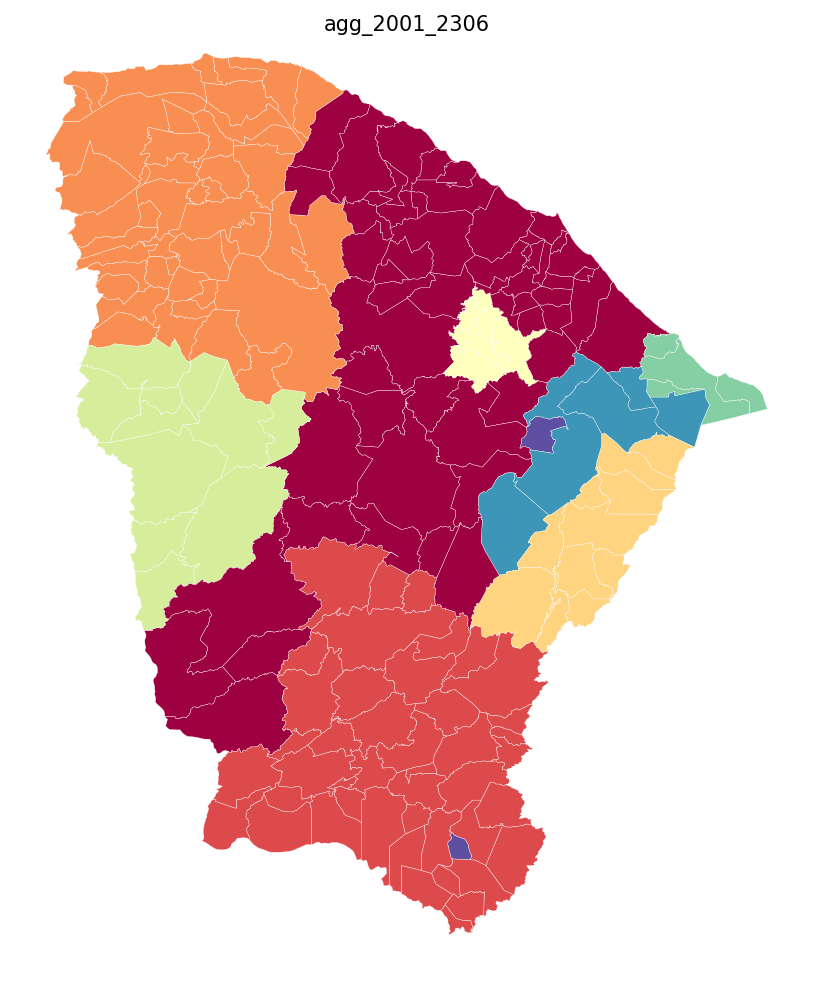

In [154]:
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

mode = 'count'
modules = geodata_df_mod[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', cmap='Spectral', scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.25, edgecolor="#ffffff",
         ax=ax_mapa)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
fig_mapa.suptitle(rf"{suffix}", fontsize=15)
fig_mapa.savefig(os.path.join(figpath, f"infomap_modules_{suffix}_{mode}.png"), dpi=250, bbox_inches='tight')

In [130]:
geodata_df_mod[['infomap_modules_count_norm_pop', 'infomap_modules_cost_norm_pop']].sample(n=10)

infomap_modules_count_norm_pop  infomap_modules_cost_norm_pop
153                               3                              3
21                                1                              1
77                                6                              6
62                                3                              3
154                               9                              9
31                                3                              3
161                               1                              1
52                                3                              3
136                               1                              1
4                                 1                              1

**Infomap to isolated macros**

In [163]:
macro_id = 1
suffix = 'agg_1801_2306'
geodata_df_mod = geodata_df.copy()
geodata_aux = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_macro{macro_id}.parquet"))

geodata_df_mod = geodata_df_mod.merge(geodata_aux, on="GEOCOD6", how="left")
geodata_df_mod = geodata_df_mod[pd.notna(geodata_df_mod["infomap_modules_count_norm_pop"])]

Text(0.5, 0.98, 'agg_1801_2306')

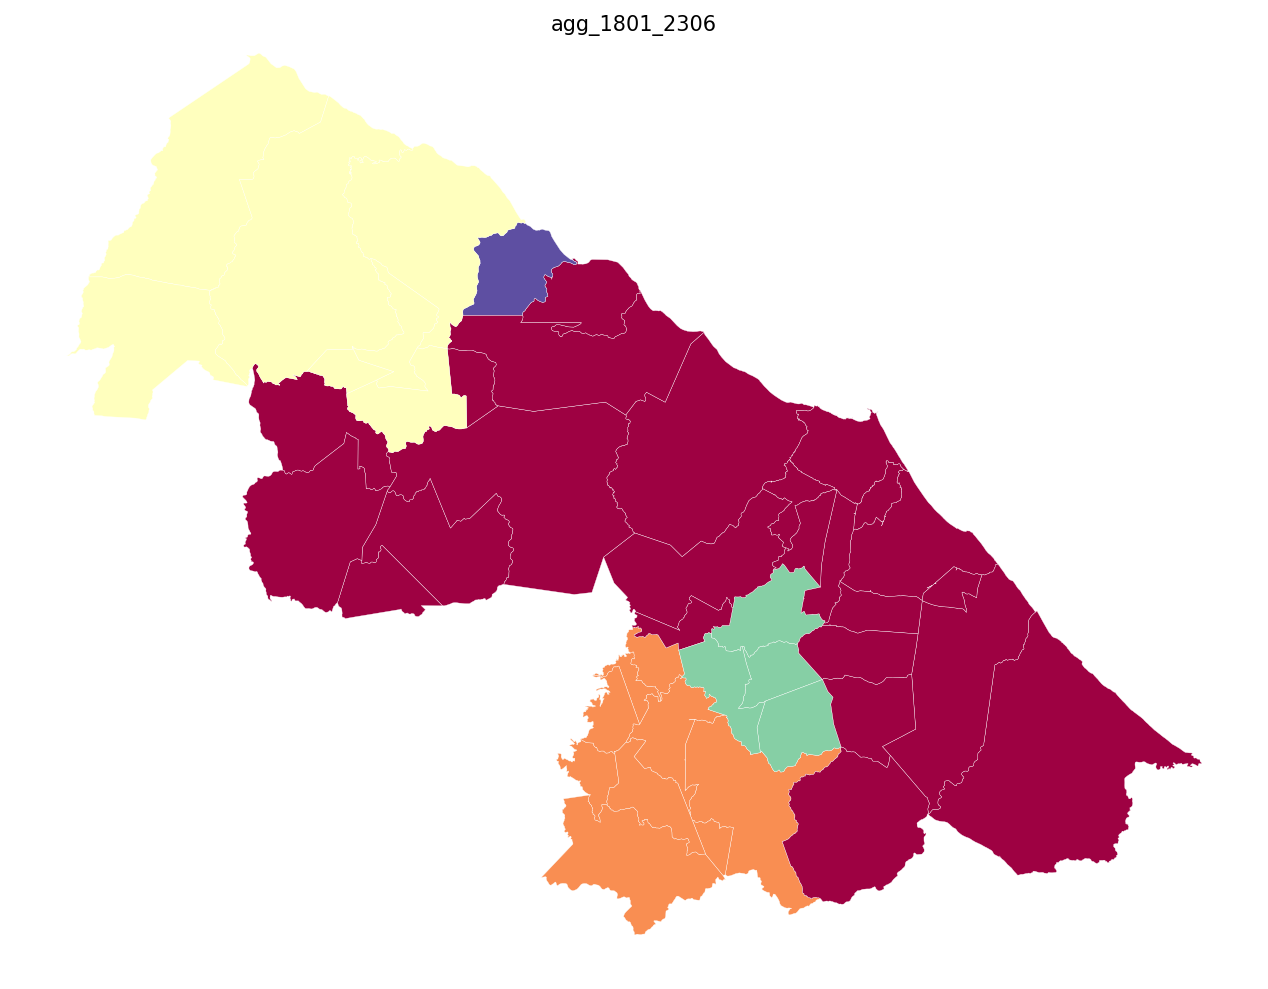

In [164]:
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

mode = 'count'
modules = geodata_df_mod[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', cmap='Spectral', scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.25, edgecolor="#ffffff",
         ax=ax_mapa)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
fig_mapa.suptitle(rf"{suffix}", fontsize=15)

**Infomap to isolated macros (proposal)**

In [165]:
macro_id = 2
suffix = 'agg_1801_2306'
geodata_df_mod = geodata_df.copy()
geodata_aux = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_macronew{macro_id}.parquet"))

geodata_df_mod = geodata_df_mod.merge(geodata_aux, on="GEOCOD6", how="left")
geodata_df_mod = geodata_df_mod[pd.notna(geodata_df_mod["infomap_modules_count_norm_pop"])]

Text(0.5, 0.98, 'agg_1801_2306')

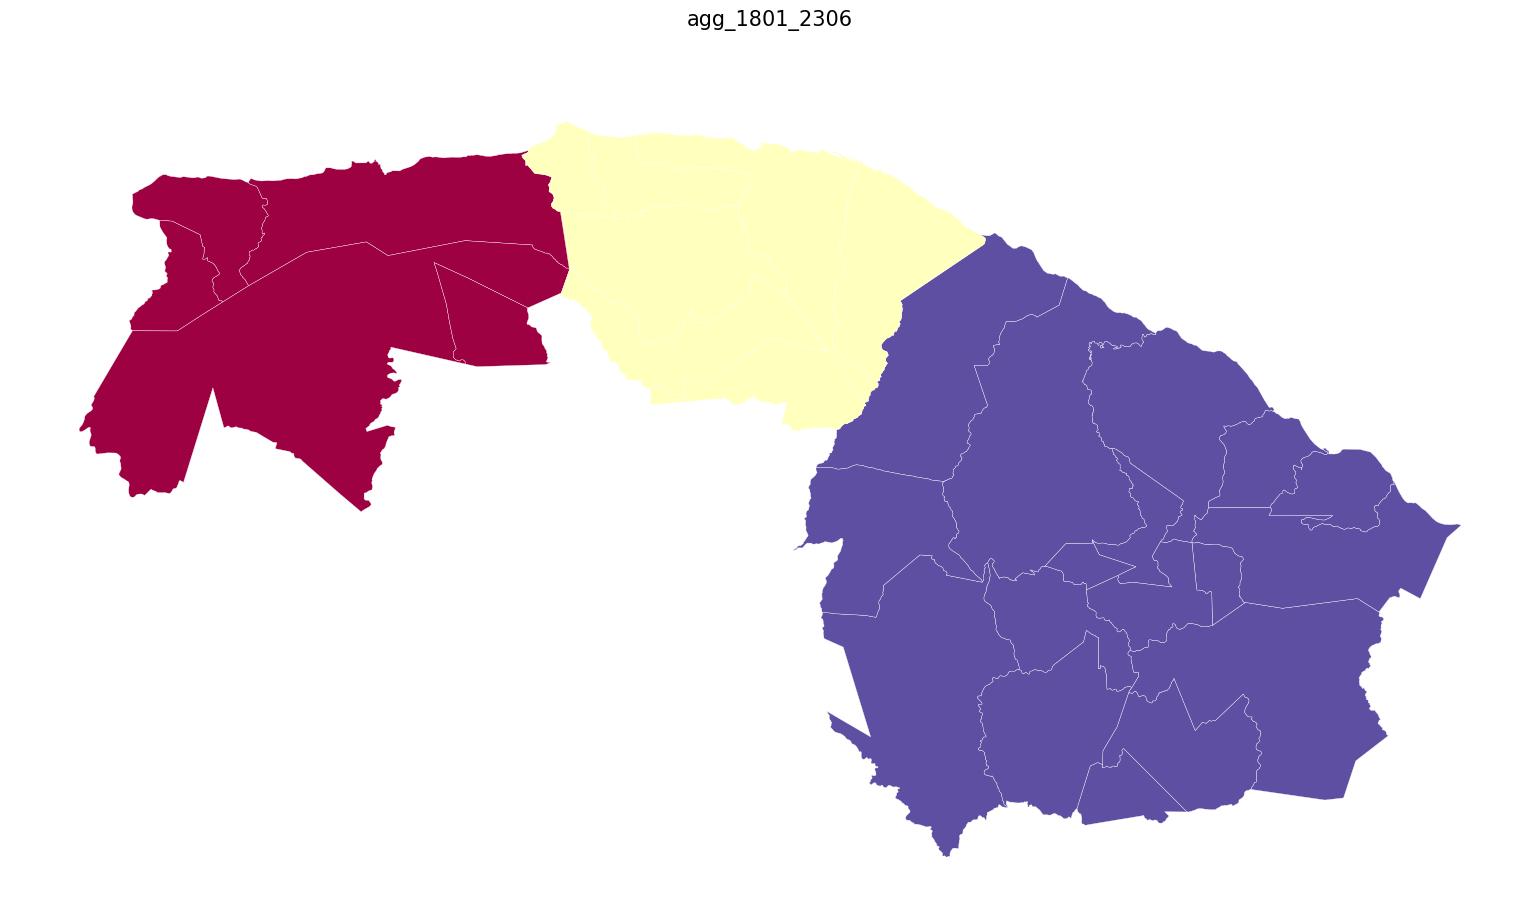

In [166]:
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

mode = 'count'
modules = geodata_df_mod[f'infomap_modules_{mode}_norm_pop'].unique().tolist()
geodata_df_mod.plot(column=f'infomap_modules_{mode}_norm_pop', cmap='Spectral', scheme="User_Defined", 
         legend=False, classification_kwds=dict(bins=sorted(modules)), linewidth=0.25, edgecolor="#ffffff",
         ax=ax_mapa)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

fig_mapa.tight_layout()
fig_mapa.suptitle(rf"{suffix}", fontsize=15)

## **6. Balance flux per city (city2city)**

### **6.1 All fluxes**

In [9]:
suffix = 'agg_self_1801_2212'
geodata_df_mod = geodata_df.copy()
geodata_aux = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}.parquet"))

geodata_df_mod = geodata_df_mod.merge(geodata_aux, on="GEOCOD6", how="left")

**Without normalization**

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_17632\616567144.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mapa.tight_layout()


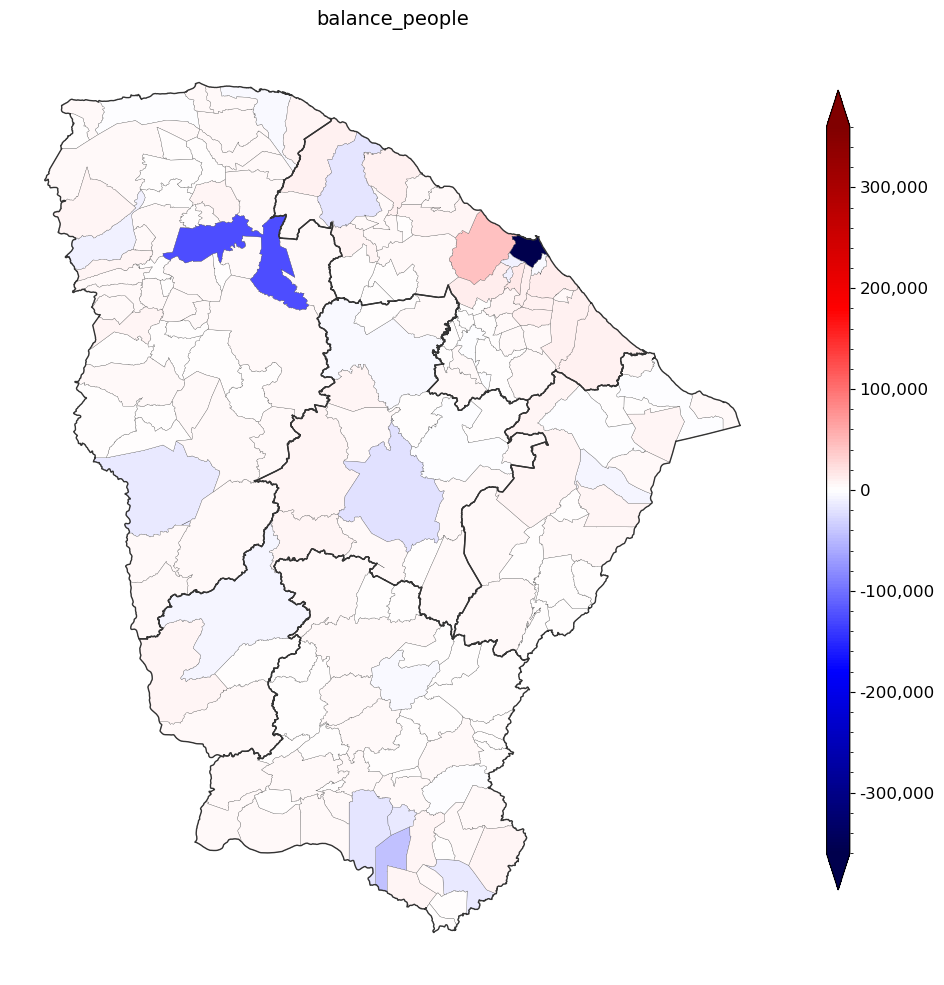

In [10]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df_mod.set_geometry("geometry_municip")

colname = "balance_people"
bounds = max([abs(geodata_df_mod[colname].min()), abs(geodata_df_mod[colname].max())])
vmin, vmax = -1*bounds, bounds

geodata_df_mod.plot(ax=ax_mapa, column=colname, edgecolor="#4d4d4d", 
             legend=False,
             cmap="seismic",
             vmin=vmin,
             vmax=vmax,
             linewidth=0.2,
             legend_kwds={
                 "fmt": "{:.0f}",
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df_mod.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#333333", linewidth=1.)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

# -- colorbar
fig_mapa = ax_mapa.get_figure()
cax = fig_mapa.add_axes([0.78, 0.1, 0.015, 0.8])
sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig_mapa.colorbar(sm, cax=cax, aspect=0.2, extend='both', format="{x:,.0f}", shrink=0.5)
cb.ax.tick_params(labelsize=12)
cb.ax.minorticks_on()

#for axis in [ax_mapa]:
#    leg = axis.get_legend()
#    lines = leg.get_lines()
#    for line in lines:
#        cur_color = line.get_markerfacecolor() 
#        line.set_marker('s')
#        line.set_markersize(15)
#        #line.set_linestyle('-')
#        #line.set_linewidth(12)
#        #line.set_color(cur_color)
#    current_labels = [t.get_text() for t in leg.get_texts()]
#    #new_labels =  [ transf_label(index, label, map_counts) for index, label in enumerate(current_labels) ]
#    #axis.legend(lines, new_labels, prop={'size': 16}, loc=4, title='Taxa de Incidência\n  Sífilis Congênita', title_fontproperties={'weight': 'bold', 'size': 13})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.suptitle(f"{colname}", fontsize=14)
fig_mapa.tight_layout()
#fig_mapa.savefig(os.path.join(figpath, "mapa_hospitais_2306.png"), dpi=200, bbox_inches='tight')

**With normalization**

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_17632\3050907433.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mapa.tight_layout()


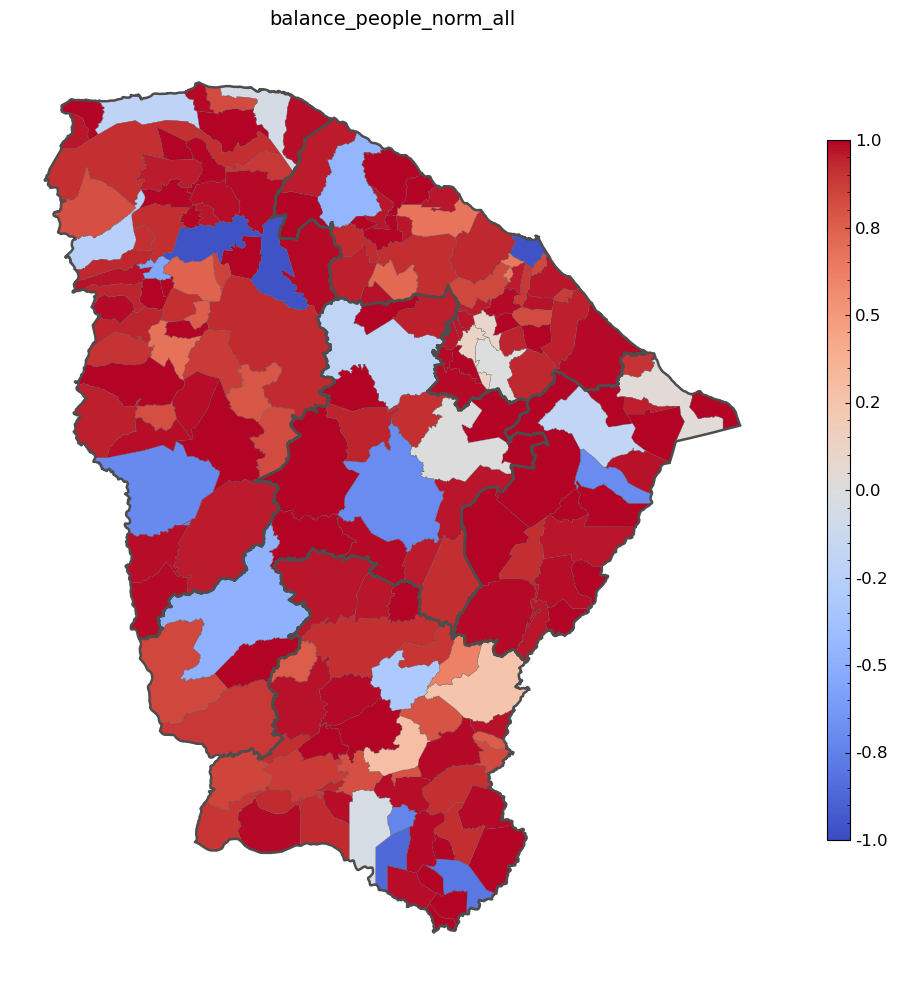

In [23]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df_mod.set_geometry("geometry_municip")

colname = "balance_people_norm_all"
bounds = max([abs(geodata_df_mod[colname].min()), abs(geodata_df_mod[colname].max())])
vmin, vmax = -1*bounds, bounds

geodata_df_mod.plot(ax=ax_mapa, column=colname, edgecolor="#4d4d4d", 
             legend=False,
             cmap="coolwarm",
             vmin=vmin,
             vmax=vmax,
             linewidth=0.2,
             #legend_kwds={
             #    "fmt": "{:.0f}",
             #},
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df_mod.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d4d4d", linewidth=1.8)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

# -- colorbar
fig_mapa = ax_mapa.get_figure()
cax = fig_mapa.add_axes([0.78, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig_mapa.colorbar(sm, cax=cax, format="{x:,.1f}", shrink=0.5)
cb.ax.tick_params(which='both', labelsize=12, direction='in')
cb.ax.minorticks_on()

#for axis in [ax_mapa]:
#    leg = axis.get_legend()
#    lines = leg.get_lines()
#    for line in lines:
#        cur_color = line.get_markerfacecolor() 
#        line.set_marker('s')
#        line.set_markersize(15)
#        #line.set_linestyle('-')
#        #line.set_linewidth(12)
#        #line.set_color(cur_color)
#    current_labels = [t.get_text() for t in leg.get_texts()]
#    #new_labels =  [ transf_label(index, label, map_counts) for index, label in enumerate(current_labels) ]
#    #axis.legend(lines, new_labels, prop={'size': 16}, loc=4, title='Taxa de Incidência\n  Sífilis Congênita', title_fontproperties={'weight': 'bold', 'size': 13})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.suptitle(f"{colname}", fontsize=14)
fig_mapa.tight_layout()
#fig_mapa.savefig(os.path.join(figpath, "mapa_hospitais_2306.png"), dpi=200, bbox_inches='tight')

### **6.2 Specific by chapter**

In [27]:
suffix = 'agg_self_1801_2212'
chapter = "ch9"
geodata_df_mod = geodata_df.copy()
geodata_aux = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}_{chapter}.parquet"))

geodata_df_mod = geodata_df_mod.merge(geodata_aux, on="GEOCOD6", how="left")

**Without normalization**

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_17632\4140422477.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mapa.tight_layout()


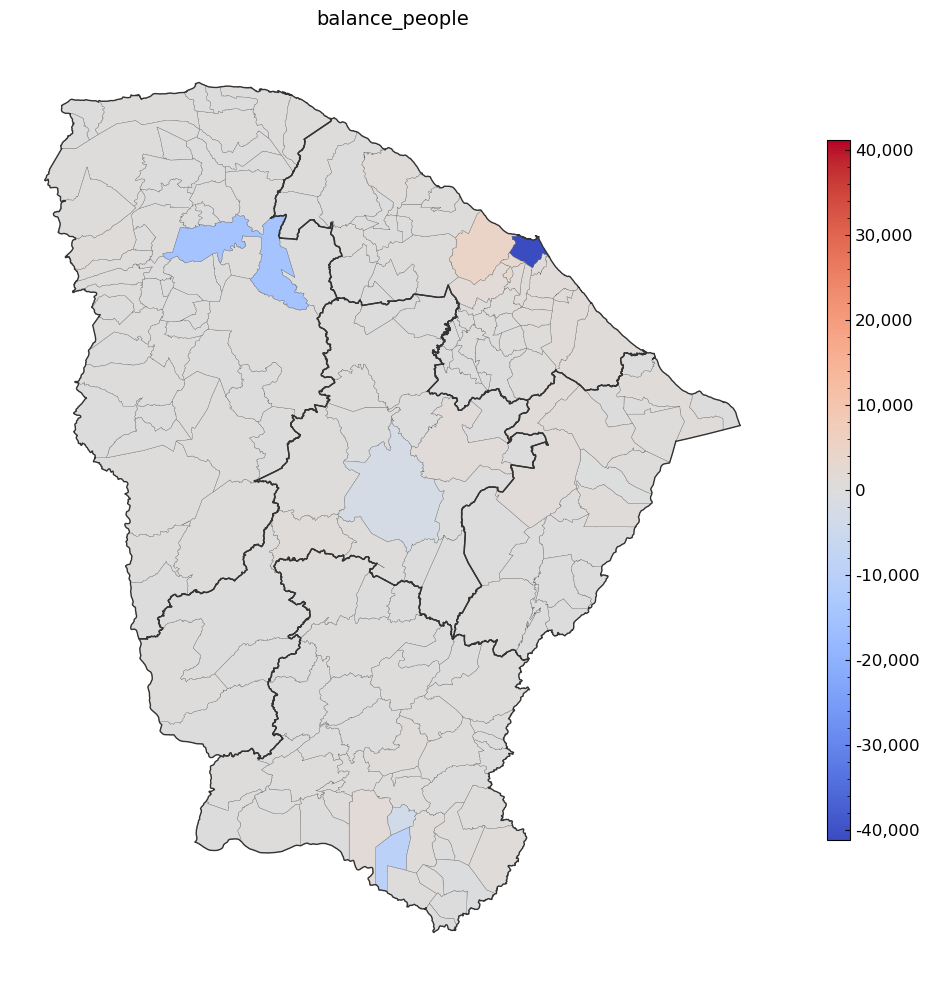

In [28]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df_mod.set_geometry("geometry_municip")

colname = "balance_people"
bounds = max([abs(geodata_df_mod[colname].min()), abs(geodata_df_mod[colname].max())])
vmin, vmax = -1*bounds, bounds

geodata_df_mod.plot(ax=ax_mapa, column=colname, edgecolor="#4d4d4d", 
             legend=False,
             cmap="coolwarm",
             vmin=vmin,
             vmax=vmax,
             linewidth=0.2,
             legend_kwds={
                 "fmt": "{:.0f}",
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df_mod.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#333333", linewidth=1.)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

# -- colorbar
fig_mapa = ax_mapa.get_figure()
cax = fig_mapa.add_axes([0.78, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig_mapa.colorbar(sm, cax=cax, format="{x:,.0f}", shrink=0.5)
cb.ax.tick_params(which='both', labelsize=12, direction='in')
cb.ax.minorticks_on()

#for axis in [ax_mapa]:
#    leg = axis.get_legend()
#    lines = leg.get_lines()
#    for line in lines:
#        cur_color = line.get_markerfacecolor() 
#        line.set_marker('s')
#        line.set_markersize(15)
#        #line.set_linestyle('-')
#        #line.set_linewidth(12)
#        #line.set_color(cur_color)
#    current_labels = [t.get_text() for t in leg.get_texts()]
#    #new_labels =  [ transf_label(index, label, map_counts) for index, label in enumerate(current_labels) ]
#    #axis.legend(lines, new_labels, prop={'size': 16}, loc=4, title='Taxa de Incidência\n  Sífilis Congênita', title_fontproperties={'weight': 'bold', 'size': 13})

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.suptitle(f"{colname}", fontsize=14)
fig_mapa.tight_layout()
#fig_mapa.savefig(os.path.join(figpath, "mapa_hospitais_2306.png"), dpi=200, bbox_inches='tight')

**With normalization**

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_17632\224373295.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mapa.tight_layout()


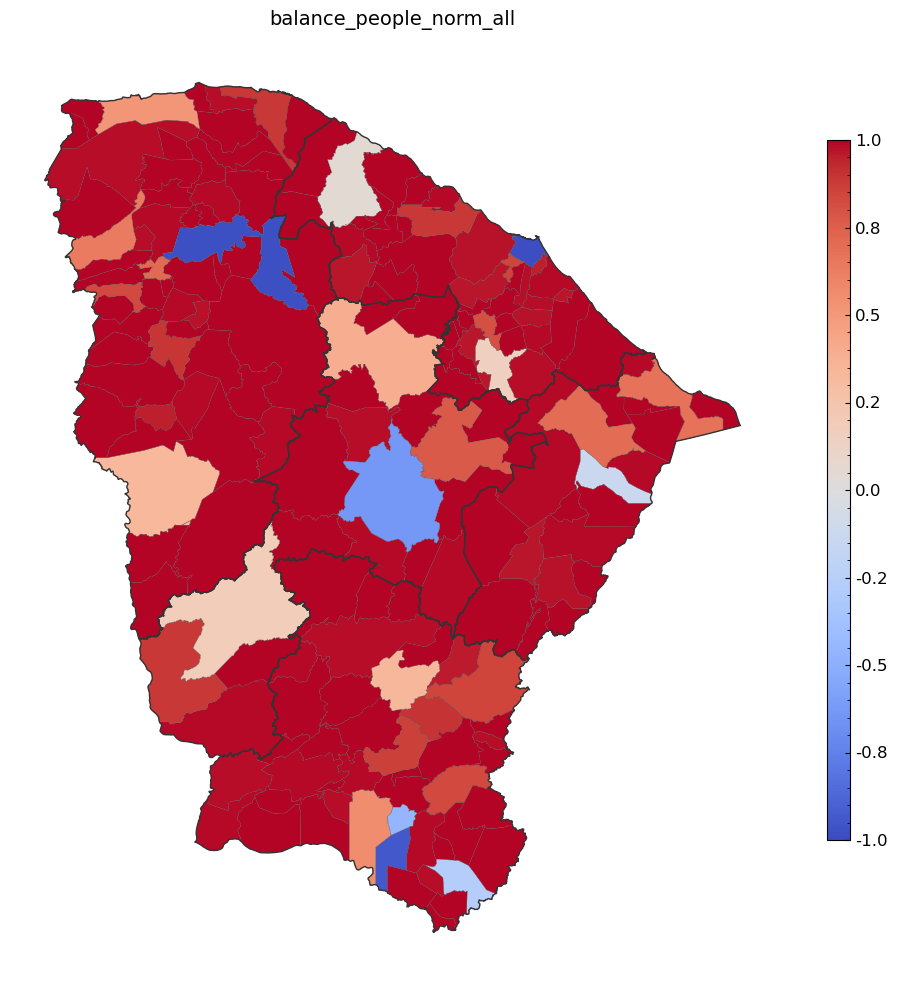

In [29]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{label[0]:,} - {label[1]:,}'.replace(",",".")
    else:
        return f'{label[0]:,} - {label[1]:,} ({counts[index]})'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))
geodata_df_mod.set_geometry("geometry_municip")

colname = "balance_people_norm_all"
bounds = max([abs(geodata_df_mod[colname].min()), abs(geodata_df_mod[colname].max())])
vmin, vmax = -1*bounds, bounds

geodata_df_mod.plot(ax=ax_mapa, column=colname, edgecolor="#4d4d4d", 
             legend=False,
             cmap="coolwarm",
             vmin=vmin,
             vmax=vmax,
             linewidth=0.2,
             legend_kwds={
                 "fmt": "{:.0f}",
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })

macro_df = geodata_df_mod.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#333333", linewidth=1.)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

# -- colorbar
fig_mapa = ax_mapa.get_figure()
cax = fig_mapa.add_axes([0.78, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig_mapa.colorbar(sm, cax=cax, format="{x:,.1f}", shrink=0.5)
cb.ax.tick_params(which='both', labelsize=12, direction='in')
cb.ax.minorticks_on()

#ax_mapa.set_title("2010", weight='bold', fontsize=18, color="#333333")
fig_mapa.suptitle(f"{colname}", fontsize=14)
fig_mapa.tight_layout()
#fig_mapa.savefig(os.path.join(figpath, "mapa_hospitais_2306.png"), dpi=200, bbox_inches='tight')

## **5. Time series of hospitals and hospital beds per macro**

In [10]:
macro_names_original = {1: 'Fortaleza', 2: 'Sertão Central', 3: 'Litoral Leste', 4: 'Norte', 5: 'Cariri'}
macro_names_proposal = {1: 'Grande Fortaleza - Maciço de Baturité',
                        2: 'Litoral Oeste - Vale do Curu - Litoral Norte',
                        3: 'Cariri', 4: 'Centro Sul', 
                        5: 'Sertão Central', 6: 'Litoral Leste - Jaguaribe',
                        7: 'Sertão dos Inhamus - Crateús',
                        8: 'Serra da Ibiapaba - Sertão de Sobral'}

In [6]:
macro_original_leitos = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_original_beds.parquet"))
macro_proposal_leitos = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_proposal_beds.parquet"))

macro_original_leitos.head()

1                                            2                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801             6406.0             9918.0   0801              499.0   
0802   0802             6450.0             9962.0   0802              499.0   
0803   0803             6450.0             9971.0   0803              499.0   
0804   0804             6611.0            10148.0   0804              499.0   
0805   0805             6632.0            10192.0   0805              499.0   

                             3                                            4  \
     macro_leitos_todos period macro_leitos_princ macro_leitos_todos period   
0801              882.0   0801              546.0              901.0   0801   
0802              882.0   0802              546.0              901.0   0802   
0803              884.0   0803              546.0              908.0   0803   
0804              884.0   0804              552.0              914.0   0804   
0805              884.0   0805              552.0              914.0   0805   

                                                5                     \
     macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801             1389.0             2414.0   0801             2180.0   
0802             1389.0             2412.0   0802             2186.0   
0803             1389.0             2418.0   0803             2192.0   
0804             1362.0             2388.0   0804             2189.0   
0805             1365.0             2391.0   0805             2184.0   

                         
     macro_leitos_todos  
0801             3362.0  
0802             3368.0  
0803             3383.0  
0804             3371.0  
0805             3367.0

### **0.1 Macro original - Number of Hospital beds**

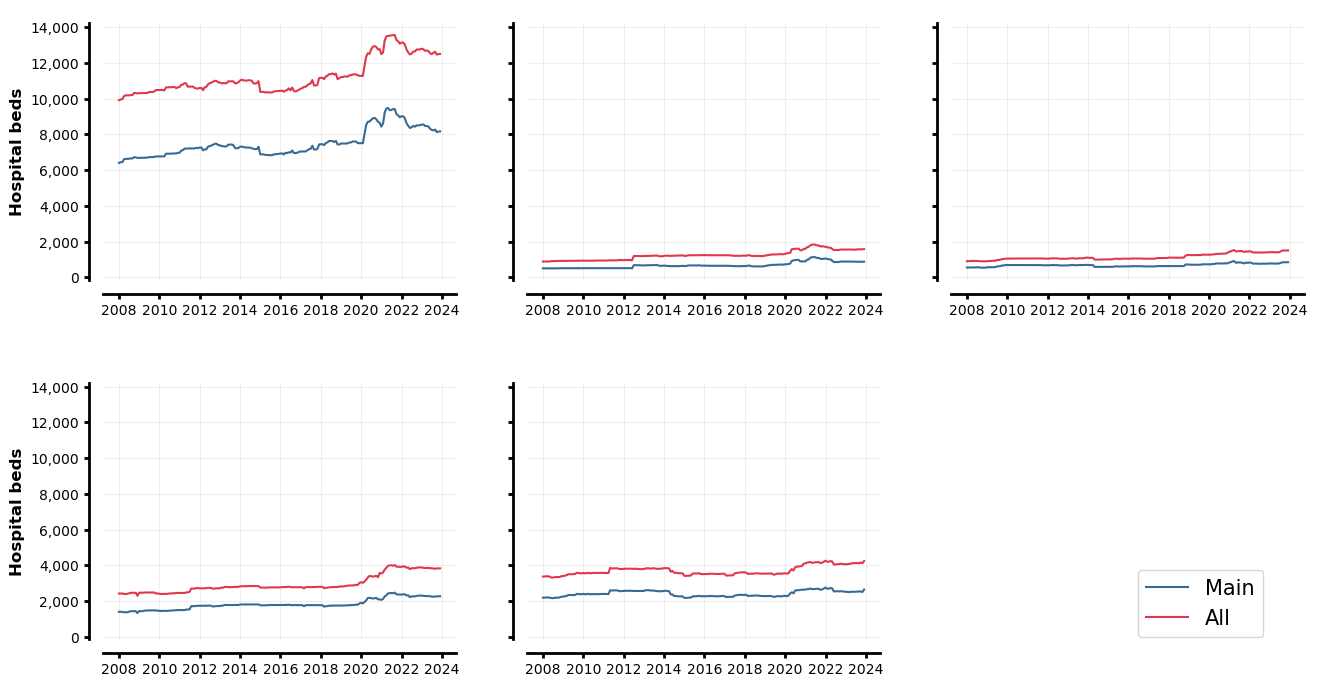

In [11]:
fig, AX = plt.subplots(2,3, figsize=(15.5,8), sharey=True)

xvalues = macro_original_leitos[1, 'period'].tolist()
xvalues = [ dt.datetime(2000+int(x[:2]), int(x[2:]), 1) for x in xvalues ]

#AX[0,0].set_title(macro_dict[1].replace("Superintendência Regional de Saúde", "SRS"))
lineprinc, = AX[0,0].plot(xvalues, macro_original_leitos[1, 'macro_leitos_princ'], color="#396a93")
linetodos, = AX[0,0].plot(xvalues, macro_original_leitos[1, 'macro_leitos_todos'], color="#e1374b")

AX[0,1].plot(xvalues, macro_original_leitos[2, 'macro_leitos_princ'], color="#396a93")
AX[0,1].plot(xvalues, macro_original_leitos[2, 'macro_leitos_todos'], color="#e1374b")

AX[0,2].plot(xvalues, macro_original_leitos[3, 'macro_leitos_princ'], color="#396a93")
AX[0,2].plot(xvalues, macro_original_leitos[3, 'macro_leitos_todos'], color="#e1374b")

AX[1,0].plot(xvalues, macro_original_leitos[4, 'macro_leitos_princ'], color="#396a93")
AX[1,0].plot(xvalues, macro_original_leitos[4, 'macro_leitos_todos'], color="#e1374b")

AX[1,1].plot(xvalues, macro_original_leitos[5, 'macro_leitos_princ'], color="#396a93")
AX[1,1].plot(xvalues, macro_original_leitos[5, 'macro_leitos_todos'], color="#e1374b")

AX[1,2].axis('off')

fig.legend([lineprinc, linetodos], ['Main', 'All'], loc=4, bbox_to_anchor=((0.88,0.1)), prop={'size':15})

#AX[0,0].set_yscale('log')
for i in range(2):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)

AX[0,0].set_ylabel("Hospital beds", fontsize=12, weight='bold')
AX[1,0].set_ylabel("Hospital beds", fontsize=12, weight='bold')

fig.subplots_adjust(hspace=0.4)

### **0.2 Macro Proposal - Number of Hospital beds**

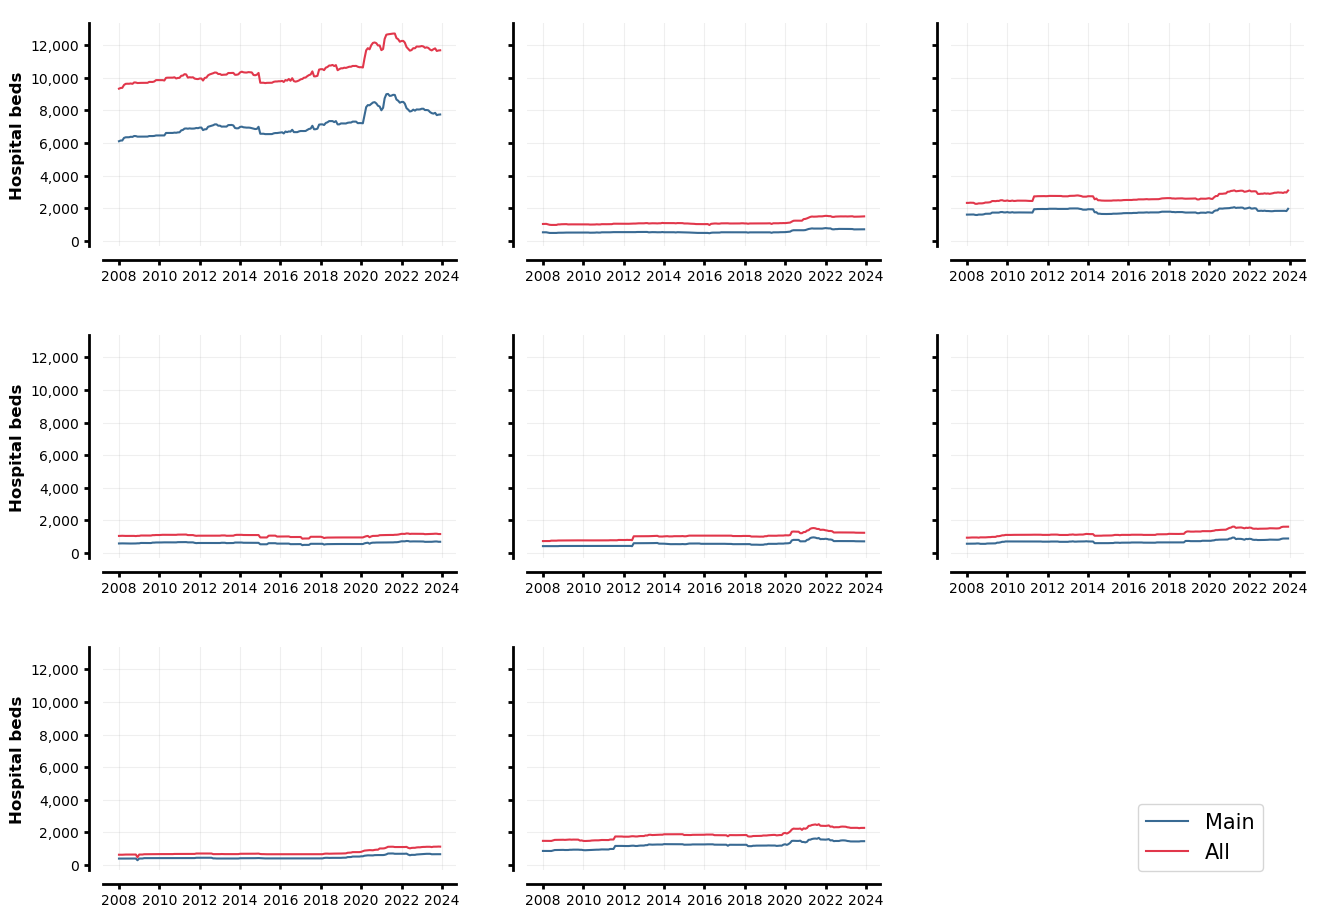

In [12]:
fig, AX = plt.subplots(3,3, figsize=(15.5,11), sharey=True)

xvalues = macro_proposal_leitos[1, 'period'].tolist()
xvalues = [ dt.datetime(2000+int(x[:2]), int(x[2:]), 1) for x in xvalues ]

#AX[0,0].set_title(macro_dict[1].replace("Superintendência Regional de Saúde", "SRS"))
lineprinc, = AX[0,0].plot(xvalues, macro_proposal_leitos[1, 'macro_leitos_princ'], color="#396a93")
linetodos, = AX[0,0].plot(xvalues, macro_proposal_leitos[1, 'macro_leitos_todos'], color="#e1374b")

AX[0,1].plot(xvalues, macro_proposal_leitos[2, 'macro_leitos_princ'], color="#396a93")
AX[0,1].plot(xvalues, macro_proposal_leitos[2, 'macro_leitos_todos'], color="#e1374b")

AX[0,2].plot(xvalues, macro_proposal_leitos[3, 'macro_leitos_princ'], color="#396a93")
AX[0,2].plot(xvalues, macro_proposal_leitos[3, 'macro_leitos_todos'], color="#e1374b")

AX[1,0].plot(xvalues, macro_proposal_leitos[4, 'macro_leitos_princ'], color="#396a93")
AX[1,0].plot(xvalues, macro_proposal_leitos[4, 'macro_leitos_todos'], color="#e1374b")

AX[1,1].plot(xvalues, macro_proposal_leitos[5, 'macro_leitos_princ'], color="#396a93")
AX[1,1].plot(xvalues, macro_proposal_leitos[5, 'macro_leitos_todos'], color="#e1374b")

AX[1,2].plot(xvalues, macro_proposal_leitos[6, 'macro_leitos_princ'], color="#396a93")
AX[1,2].plot(xvalues, macro_proposal_leitos[6, 'macro_leitos_todos'], color="#e1374b")

AX[2,0].plot(xvalues, macro_proposal_leitos[7, 'macro_leitos_princ'], color="#396a93")
AX[2,0].plot(xvalues, macro_proposal_leitos[7, 'macro_leitos_todos'], color="#e1374b")

AX[2,1].plot(xvalues, macro_proposal_leitos[8, 'macro_leitos_princ'], color="#396a93")
AX[2,1].plot(xvalues, macro_proposal_leitos[8, 'macro_leitos_todos'], color="#e1374b")

AX[2,2].axis('off')

fig.legend([lineprinc, linetodos], ['Main', 'All'], loc=4, bbox_to_anchor=((0.88,0.1)), prop={'size':15})

for i in range(3):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)

AX[0,0].set_ylabel("Hospital beds", fontsize=12, weight='bold')
AX[1,0].set_ylabel("Hospital beds", fontsize=12, weight='bold')
AX[2,0].set_ylabel("Hospital beds", fontsize=12, weight='bold')

fig.subplots_adjust(hspace=0.4)